In [48]:
from casadi import *
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [55]:
def run_model(T, N, tau_theta, tau_phi, lam, init1, init2, umax=inf, name=None, return_cost=False):
    # Declare model variables
    x1 = MX.sym('x1')
    x2 = MX.sym('x2')
    x = vertcat(x1, x2)
    u = MX.sym('u')

    # Model equations
    xdot = vertcat(-x1/tau_theta, -u*x2+x1/tau_theta)

    # Objective term
    L = (x1+x2)**2+lam*u**2 #x1**2+x2**2
    
    # Formulate discrete time dynamics
    if False:
        # CVODES from the SUNDIALS suite
        dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
        opts = {'tf':T/N}
        F = integrator('F', 'cvodes', dae, opts)
    else:
        # Fixed step Runge-Kutta 4 integrator
        M = 4 # RK4 steps per interval
        DT = T/N/M
        f = Function('f', [x, u], [xdot, L])
        X0 = MX.sym('X0', 2)
        U = MX.sym('U')
        X = X0
        Q = 0
        for j in range(M):
            k1, k1_q = f(X, U)
            k2, k2_q = f(X + DT/2 * k1, U)
            k3, k3_q = f(X + DT/2 * k2, U)
            k4, k4_q = f(X + DT * k3, U)
            X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
            Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
        F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])
        
    # Start with an empty NLP
    w = []
    w0 = []
    lbw = []
    ubw = []
    J = 0
    g = []
    lbg = []
    ubg = []

    # Formulate the NLP
    Xk = MX([init1, init2])
    for k in range(N):
        # New NLP variable for the control
        Uk = MX.sym('U_' + str(k))
        w += [Uk]
        lbw += [-inf]
        ubw += [umax]
        w0 += [0]

        # Integrate till the end of the interval
        Fk = F(x0=Xk, p=Uk)
        Xk = Fk['xf']
        J=J+Fk['qf']

        # Add inequality constraint
        g += [Xk[0]]
        lbg += [-inf]
        ubg += [inf]
        
    # Create an NLP solver
    prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', prob)

    # Solve the NLP
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x']
    
    if return_cost: return(sol['f'])
    
    # Plot the solution
    u_opt = w_opt
    x_opt = [[init1, init2]]
    for k in range(N):
        Fk = F(x0=x_opt[-1], p=u_opt[k])
        x_opt += [Fk['xf'].full()]
    x1_opt = [r[0] for r in x_opt]
    x2_opt = [r[1] for r in x_opt]

    tgrid = [T/N*k for k in range(N+1)]
    
    plt.figure(1)
    plt.clf()
    plt.plot(tgrid, x1_opt, '--')
    plt.plot(tgrid, x2_opt, '-')
    plt.step(tgrid, vertcat(DM.nan(1), u_opt), '-.')
    plt.xlabel('t')
    plt.legend(['x1','x2','u'])
    plt.title('cost: {}'.format(sol['f']))
    plt.grid()
    if name: plt.title('cost: {}, {}'.format(sol['f'], name))
    if umax < inf: plt.title('cost: {}, umax: {}'.format(sol['f'], umax))
    if name: plt.savefig('graphs/{}.png'.format(name))
    plt.show()
    
    return(sol)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

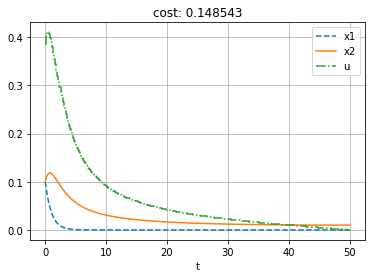

In [56]:
T = 50. # Time horizon
N = 300 # number of control intervals
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = .1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
sol = run_model(T, N, tau_theta, tau_phi, lam, init1, init2);

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

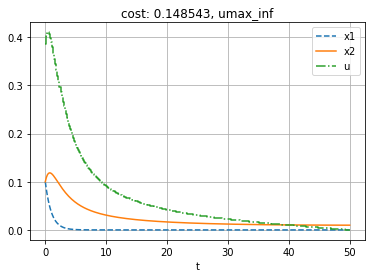

In [57]:
T = 50. # Time horizon
N = 300 # number of control intervals
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = .1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
sol = run_model(T, N, tau_theta, tau_phi, lam, init1, init2, name='umax_inf');

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

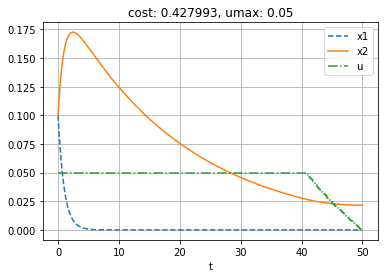

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

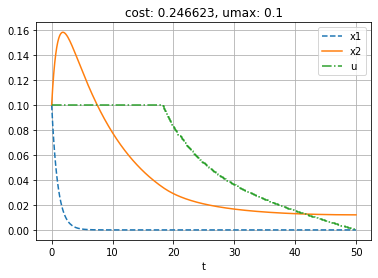

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

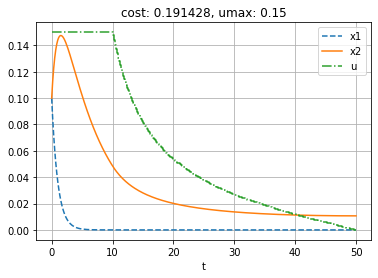

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

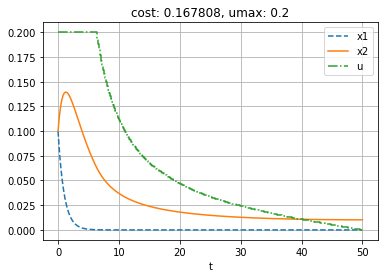

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

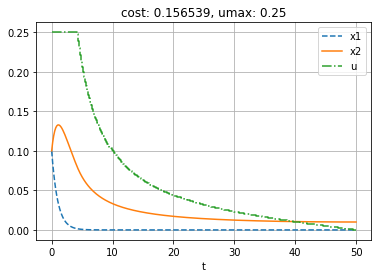

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

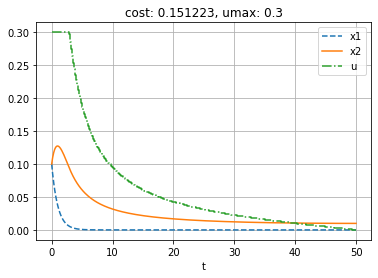

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

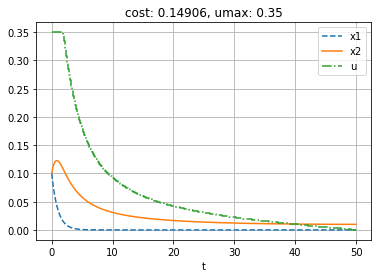

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

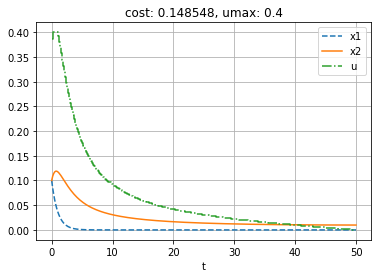

In [58]:
T = 50. # Time horizon
N = 300 # number of control intervals
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = .1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
umaxlst = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

for umax in umaxlst:
    sol = run_model(T, N, tau_theta, tau_phi, lam, init1, init2, umax, 'umax_' + str(umax));

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

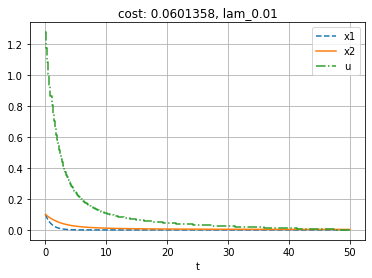

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

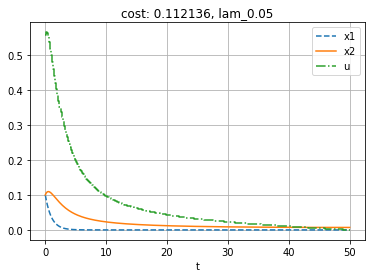

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

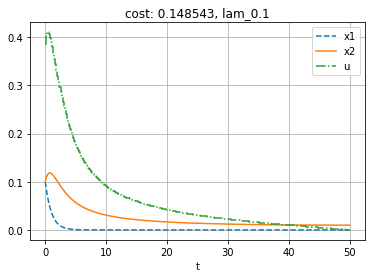

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

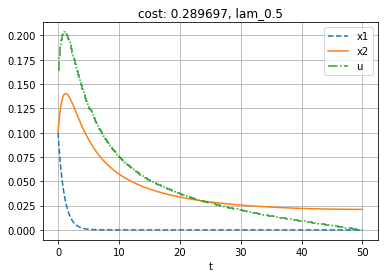

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

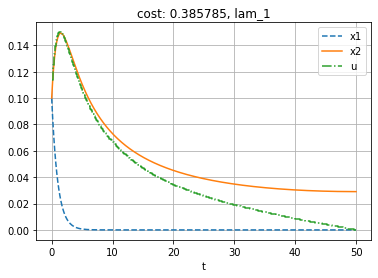

In [59]:
T = 50. # Time horizon
N = 300 # number of control intervals
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lamlst = [0.01, 0.05, 0.1, 0.5, 1]
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()

for lam in lamlst:
    sol = run_model(T, N, tau_theta, tau_phi, lam, init1, init2, name='lam_' + str(lam));

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

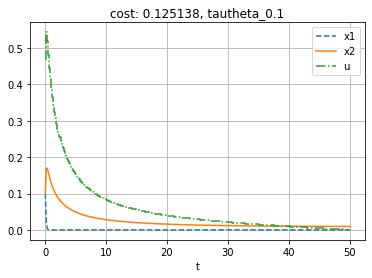

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

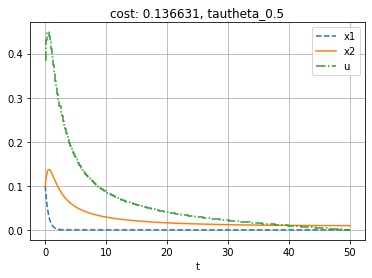

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

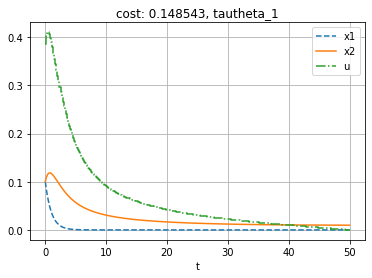

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

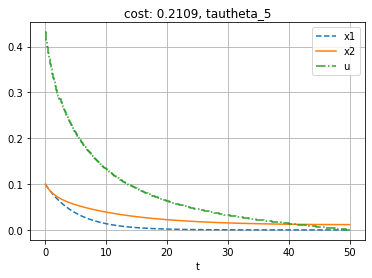

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

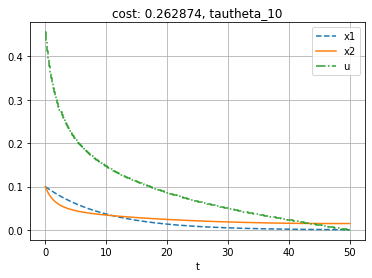

In [60]:
T = 50. # Time horizon
N = 300 # number of control intervals
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = 0.1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
tau_thetalst = [0.1, 0.5, 1, 5, 10]

for tau_theta in tau_thetalst:
    sol = run_model(T, N, tau_theta, tau_phi, lam, init1, init2, name='tautheta_' + str(tau_theta));

In [78]:
T = 10. # Time horizon
N = 10 # number of control intervals
tau_theta = 10*np.random.uniform()
tau_phi = 10*np.random.uniform()
init1 = np.pi/20*np.random.normal()
init2 = np.pi/20*np.random.normal()

fun = lambda L: run_model(T, N, tau_theta, tau_phi, L, init1, init2, return_cost=True)
scipy.optimize.fmin(func=fun, x0=[1])

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  29 -3.3838571e+01 0.00e+00 3.26e-02  -3.8 1.84e-01    -  1.00e+00 8.36e-04f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.3839207e+01 0.00e+00 2.28e-03  -3.8 8.20e-02    -  1.00e+00 1.00e+00f  1
  31 -3.3839226e+01 0.00e+00 7.07e-05  -3.8 1.53e-02    -  1.00e+00 1.00e+00f  1
  32 -3.3840415e+01 0.00e+00 1.31e-07  -5.7 8.00e-04    -  1.00e+00 1.00e+00f  1
  33 -3.3840430e+01 0.00e+00 3.34e-12  -8.6 4.59e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  -3.3840429650357116e+01   -3.3840429650357116e+01
Dual infeasibility......:   3.3448161854968029e-12    3.3448161854968029e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5093621781102446e-09    2.5093621781102446e-09
Overall NLP error.......:   2.5093621781102446e-09    2.5093621781102446e-09


Number of objective funct

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  13 -5.3524460e+02 0.00e+00 5.99e+01  -1.0 1.54e+00   1.7 1.00e+00 2.11e-02f  1
  14 -7.7932690e+02 0.00e+00 6.62e+01  -1.0 6.44e+00   1.2 1.00e+00 4.18e-01f  1
  15 -7.8276384e+02 0.00e+00 5.40e+01  -1.0 1.61e+00   1.6 1.00e+00 1.67e-02f  1
  16 -1.0103075e+03 0.00e+00 6.60e+01  -1.0 1.04e+01   1.2 1.00e+00 2.17e-01f  1
  17 -1.0139686e+03 0.00e+00 4.51e+01  -1.0 1.58e+00   1.6 1.00e+00 1.64e-02f  1
  18 -1.2212521e+03 0.00e+00 6.56e+01  -1.0 1.84e+01   1.1 5.83e-01 1.08e-01f  1
  19 -1.2256968e+03 0.00e+00 4.66e+01  -1.0 1.92e+00   1.5 1.00e+00 1.99e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.4179759e+03 0.00e+00 6.51e+01  -1.0 4.43e+01   1.1 2.41e-01 4.19e-02f  1
  21 -1.4238926e+03 0.00e+00 4.73e+01  -1.0 2.31e+00   1.5 1.00e+00 2.70e-02f  1
  22 -1.4775759e+03 0.00e+00 5.45e+01  -1.0 6.63e-01   1.9 1.00e+00 1.00e+00f  1
  23 -1.5850930e+03 0.00e+00 6.59e+01  -1.0 3.22e+00   1.4 1.00e+00 3.47e-01f  1
  24 -1.5867317e+03 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  15 -9.1250681e+03 0.00e+00 3.68e+02  -1.0 1.33e+00   2.5 1.00e+00 1.08e-02f  1
  16 -1.0209002e+04 0.00e+00 4.66e+02  -1.0 8.66e+00   2.1 1.00e+00 1.54e-01f  1
  17 -1.0224778e+04 0.00e+00 3.52e+02  -1.0 1.48e+00   2.5 1.00e+00 1.10e-02f  1
  18 -1.1281697e+04 0.00e+00 4.66e+02  -1.0 1.19e+01   2.0 9.65e-01 1.29e-01f  1
  19 -1.1296960e+04 0.00e+00 3.26e+02  -1.0 1.60e+00   2.4 1.00e+00 1.11e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.2335406e+04 0.00e+00 4.66e+02  -1.0 1.82e+01   2.0 5.90e-01 1.03e-01f  1
  21 -1.2349038e+04 0.00e+00 3.33e+02  -1.0 1.93e+00   2.4 1.00e+00 9.78e-03f  1
  22 -1.3399959e+04 0.00e+00 4.66e+02  -1.0 3.66e+01   1.9 2.74e-01 6.96e-02f  1
  23 -1.3413360e+04 0.00e+00 4.12e+02  -1.0 2.84e+00   2.3 1.00e+00 8.98e-03f  1
  24 -1.3448578e+04 0.00e+00 1.71e+02  -1.0 3.05e-01   2.8 1.00e+00 7.08e-01f  1
  25 -1.3768473e+04 0.00e+00 2.78e+02  -1.0 1.43e+00   2.3 1.00e+00 1.00e+00f  1
  26 -1.3956381e+04 0.00e+00

  11 -5.5594705e+01 0.00e+00 6.72e+01  -1.0 9.69e-02   2.8 1.00e+00 1.00e+00f  1
  12 -4.6545869e+02 0.00e+00 1.93e+02  -1.0 8.34e-01   2.4 1.00e+00 1.00e+00f  1
  13 -8.1785294e+02 0.00e+00 2.56e+02  -1.0 4.16e-01   2.8 1.00e+00 1.00e+00f  1
  14 -1.1118724e+04 0.00e+00 9.44e+02  -1.0 4.73e+00   2.3 1.00e+00 9.61e-01f  1
  15 -1.1281907e+04 0.00e+00 9.47e+02  -1.0 2.37e+00   2.7 1.00e+00 1.92e-02f  1
  16 -1.1769912e+04 0.00e+00 8.83e+02  -1.0 2.72e+01   2.3 4.66e-01 6.03e-03f  1
  17 -1.3047348e+04 0.00e+00 9.06e+02  -1.0 2.52e+00   2.7 1.00e+00 1.58e-01f  1
  18 -1.5414283e+04 0.00e+00 9.06e+02  -1.0 6.41e+01   2.2 1.71e-01 1.26e-02f  1
  19 -1.5763279e+04 0.00e+00 8.53e+02  -1.0 2.95e+00   2.6 1.00e+00 4.91e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.6997220e+04 0.00e+00 9.10e+02  -1.0 8.33e-01   3.1 1.00e+00 5.86e-01f  1
  21 -1.7296986e+04 0.00e+00 8.27e+02  -1.0 3.44e+00   2.6 1.00e+00 4.45e-02f  1
  22 -1.8942884e+04 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -4.1113348e+04 0.00e+00 2.25e+03  -1.0 2.92e+00   3.1 1.00e+00 6.05e-02f  1
  21 -4.2147434e+04 0.00e+00 2.32e+03  -1.0 8.42e-01   3.5 1.00e+00 1.96e-01f  1
  22 -4.5909493e+04 0.00e+00 2.46e+03  -1.0 3.61e+00   3.0 1.00e+00 1.53e-01f  1
  23 -4.6132556e+04 0.00e+00 2.19e+03  -1.0 9.35e-01   3.4 1.00e+00 4.33e-02f  1
  24 -5.1106145e+04 0.00e+00 2.55e+03  -1.0 4.33e+00   3.0 1.00e+00 2.04e-01f  1
  25 -5.1174012e+04 0.00e+00 2.10e+03  -1.0 1.03e+00   3.4 1.00e+00 1.03e-02f  1
  26 -5.6498237e+04 0.00e+00 2.55e+03  -1.0 5.19e+00   2.9 1.00e+00 2.17e-01f  1
  27 -5.6559294e+04 0.00e+00 2.36e+03  -1.0 1.34e+00   3.3 1.00e+00 8.39e-03f  1
  28 -5.9299337e+04 0.00e+00 2.29e+03  -1.0 6.34e+00   2.9 1.00e+00 1.18e-01f  1
  29 -6.1987801e+04 0.00e+00 2.55e+03  -1.0 1.51e+00   3.3 1.00e+00 4.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -6.2035570e+04 0.00e+00

  23 -1.1348516e+05 0.00e+00 4.00e+03  -1.0 2.07e+00   3.4 1.00e+00 8.46e-03f  1
  24 -1.2427160e+05 0.00e+00 5.11e+03  -1.0 4.15e+01   3.0 2.69e-01 3.32e-02f  1
  25 -1.2441728e+05 0.00e+00 3.67e+03  -1.0 2.26e+00   3.4 1.00e+00 6.47e-03f  1
  26 -1.2570683e+05 0.00e+00 3.87e+03  -1.0 6.47e-01   3.8 1.00e+00 3.78e-01f  1
  27 -1.3533428e+05 0.00e+00 5.12e+03  -1.0 2.88e+00   3.3 1.00e+00 5.33e-01f  1
  28 -1.3544434e+05 0.00e+00 5.09e+03  -1.0 1.03e+00   3.8 1.00e+00 1.49e-02f  1
  29 -1.3553398e+05 0.00e+00 3.10e+03  -1.0 2.78e+00   3.3 1.00e+00 9.32e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.3824034e+05 0.00e+00 3.68e+03  -1.0 7.19e-01   3.7 1.00e+00 1.00e+00f  1
  31 -1.4682956e+05 0.00e+00 5.12e+03  -1.0 4.13e+00   3.2 1.00e+00 4.25e-01f  1
  32 -1.4692964e+05 0.00e+00 5.11e+03  -1.0 1.36e+00   3.7 1.00e+00 1.29e-02f  1
  33 -1.4695062e+05 0.00e+00 1.72e+03  -1.0 2.44e+00   3.2 1.00e+00 4.81e-03f  1
  34 -1.4798014e+05 0.00e+00

  14 -1.4628593e+05 0.00e+00 1.03e+04  -1.0 1.06e+03   3.2 1.09e-02 4.24e-04f  1
  15 -1.4655808e+05 0.00e+00 9.31e+03  -1.0 3.38e+00   3.6 1.00e+00 2.32e-03f  1
  16 -1.6349962e+05 0.00e+00 1.02e+04  -1.0 9.25e-01   4.1 1.00e+00 6.06e-01f  1
  17 -1.6453726e+05 0.00e+00 9.02e+03  -1.0 3.97e+00   3.6 1.00e+00 7.86e-03f  1
  18 -1.7110938e+05 0.00e+00 9.45e+03  -1.0 1.03e+00   4.0 1.00e+00 2.54e-01f  1
  19 -1.8458191e+05 0.00e+00 1.02e+04  -1.0 5.13e+00   3.5 1.00e+00 9.75e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.8491230e+05 0.00e+00 8.77e+03  -1.0 1.15e+00   4.0 1.00e+00 1.17e-02f  1
  21 -2.0557567e+05 0.00e+00 1.03e+04  -1.0 6.07e+00   3.5 1.00e+00 1.51e-01f  1
  22 -2.0581952e+05 0.00e+00 8.85e+03  -1.0 1.34e+00   3.9 1.00e+00 6.81e-03f  1
  23 -2.2710671e+05 0.00e+00 1.03e+04  -1.0 7.66e+00   3.4 1.00e+00 1.46e-01f  1
  24 -2.2734776e+05 0.00e+00 9.69e+03  -1.0 1.71e+00   3.9 1.00e+00 6.53e-03f  1
  25 -2.3640417e+05 0.00e+00

  13 -2.4092735e+05 0.00e+00 2.05e+04  -1.0 5.75e+00   3.7 1.00e+00 5.81e-01f  1
  14 -2.4351016e+05 0.00e+00 2.06e+04  -1.0 2.07e+00   4.1 1.00e+00 1.61e-02f  1
  15 -2.4393717e+05 0.00e+00 1.88e+04  -1.0 1.69e+01   3.6 7.54e-01 3.98e-04f  1
  16 -2.7969236e+05 0.00e+00 2.05e+04  -1.0 2.23e+00   4.1 1.00e+00 2.45e-01f  1
  17 -2.8286061e+05 0.00e+00 1.84e+04  -1.0 2.91e+01   3.6 3.99e-01 1.93e-03f  1
  18 -3.2123369e+05 0.00e+00 2.04e+04  -1.0 2.56e+00   4.0 1.00e+00 2.57e-01f  1
  19 -3.5923106e+05 0.00e+00 2.01e+04  -1.0 9.03e+01   3.5 1.28e-01 8.16e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.6612691e+05 0.00e+00 1.84e+04  -1.0 3.02e+00   4.0 1.00e+00 3.92e-02f  1
  21 -3.6964465e+05 0.00e+00 1.77e+04  -1.0 8.14e-01   4.4 1.00e+00 1.05e-01f  1
  22 -4.0867909e+05 0.00e+00 2.05e+04  -1.0 3.57e+00   3.9 1.00e+00 2.45e-01f  1
  23 -4.0915661e+05 0.00e+00 1.67e+04  -1.0 8.96e-01   4.3 1.00e+00 9.86e-03f  1
  24 -4.4004789e+05 0.00e+00

   6 -3.4673065e+01 0.00e+00 3.41e+02  -1.0 1.62e-02   4.3 1.00e+00 1.00e+00f  1
   7 -7.6356031e+03 0.00e+00 4.98e+03  -1.0 7.09e-01   3.8 1.00e+00 1.00e+00f  1
   8 -1.8061739e+04 0.00e+00 7.66e+03  -1.0 4.09e-01   4.3 1.00e+00 1.00e+00f  1
   9 -2.3927483e+04 0.00e+00 8.82e+03  -1.0 1.77e-01   4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.5054350e+04 0.00e+00 1.45e+04  -1.0 8.73e-01   4.2 1.00e+00 1.00e+00f  1
  11 -8.9528642e+04 0.00e+00 1.71e+04  -1.0 3.84e-01   4.6 1.00e+00 1.00e+00f  1
  12 -2.8827888e+05 0.00e+00 3.06e+04  -1.0 2.07e+00   4.2 1.00e+00 1.00e+00f  1
  13 -4.1447742e+05 0.00e+00 3.67e+04  -1.0 9.30e-01   4.6 1.00e+00 1.00e+00f  1
  14 -5.2014265e+05 0.00e+00 4.11e+04  -1.0 5.56e+00   4.1 1.00e+00 1.21e-01f  1
  15 -5.2126380e+05 0.00e+00 4.10e+04  -1.0 1.43e+00   4.5 1.00e+00 4.70e-03f  1
  16 -5.2613999e+05 0.00e+00 3.85e+04  -1.0 7.44e+00   4.1 1.00e+00 4.86e-03f  1
  17 -5.8267167e+05 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  11 -2.7384712e+01 0.00e+00 5.27e+02  -1.0 7.59e-03   4.8 1.00e+00 1.00e+00f  1
  12 -1.2696312e+03 0.00e+00 3.50e+03  -1.0 1.52e-01   4.4 1.00e+00 1.00e+00f  1
  13 -2.7372030e+03 0.00e+00 5.14e+03  -1.0 8.34e-02   4.8 1.00e+00 1.00e+00f  1
  14 -1.4403603e+06 0.00e+00 1.18e+05  -1.0 5.74e+00   4.3 1.00e+00 1.00e+00f  1
  15 -1.5778460e+06 0.00e+00 1.23e+05  -1.0 3.36e+00   4.7 1.00e+00 8.34e-02f  1
  16 -1.5792550e+06 0.00e+00 1.23e+05  -1.0 9.74e-01   5.2 1.00e+00 2.87e-03f  1
  17 -1.5831272e+06 0.00e+00 1.15e+05  -1.0 3.96e+00   4.7 1.00e+00 2.40e-03f  1
  18 -1.7576999e+06 0.00e+00 1.23e+05  -1.0 1.05e+00   5.1 1.00e+00 3.96e-01f  1
  19 -1.7597712e+06 0.00e+00 1.12e+05  -1.0 4.71e+00   4.6 1.00e+00 9.55e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.8303191e+06 0.00e+00 1.15e+05  -1.0 1.16e+00   5.1 1.00e+00 1.72e-01f  1
  21 -1.9803406e+06 0.00e+00 1.23e+05  -1.0 6.12e+00   4.6 1.00e+00 6.59e-02f  1
  22 -1.9825778e+06 0.00e+00

  41 -4.3734655e+06 0.00e+00 1.05e+05  -1.0 1.44e+00   5.0 1.00e+00 1.65e-01f  1
  42 -4.7100401e+06 0.00e+00 1.64e+05  -1.0 1.95e+01   4.5 5.21e-01 1.16e-01f  1
  43 -4.7141510e+06 0.00e+00 1.65e+05  -1.0 2.82e+00   4.9 1.00e+00 7.97e-03f  1
  44 -4.7155741e+06 0.00e+00 1.17e+05  -1.0 2.91e+01   4.4 2.91e-01 8.62e-04f  1
  45 -4.7430930e+06 0.00e+00 6.73e+04  -1.0 1.14e+00   4.9 1.00e+00 3.93e-01f  1
  46 -4.7711618e+06 0.00e+00 7.75e+04  -1.0 3.88e-01   5.3 1.00e+00 1.00e+00f  1
  47 -4.9679812e+06 0.00e+00 1.28e+05  -1.0 1.92e+00   4.8 1.00e+00 1.00e+00f  1
  48 -5.0851119e+06 0.00e+00 1.50e+05  -1.0 8.44e-01   5.2 1.00e+00 1.00e+00f  1
  49 -5.1731488e+06 0.00e+00 1.65e+05  -1.0 4.54e+00   4.8 1.00e+00 1.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -5.1740707e+06 0.00e+00 1.64e+05  -1.0 1.25e+00   5.2 1.00e+00 4.49e-03f  1
  51 -5.1740799e+06 0.00e+00 1.04e+03  -1.0 3.96e-02    -  1.00e+00 1.41e-03f  1
  52 -5.1740799e+06 0.00e+00

  37 -8.6935102e+06 0.00e+00 1.98e+05  -1.0 2.93e+00   5.1 1.00e+00 1.56e-04f  1
  38 -8.8558668e+06 0.00e+00 2.33e+05  -1.0 7.39e-01   5.5 1.00e+00 9.17e-01f  1
  39 -9.4220962e+06 0.00e+00 3.28e+05  -1.0 4.30e+00   5.0 1.00e+00 4.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -9.4287267e+06 0.00e+00 3.29e+05  -1.0 1.42e+00   5.5 1.00e+00 1.28e-02f  1
  41 -9.4288122e+06 0.00e+00 1.10e+05  -1.0 2.59e+00   5.0 1.00e+00 9.02e-05f  1
  42 -9.4878264e+06 0.00e+00 1.35e+05  -1.0 5.48e-01   5.4 1.00e+00 8.79e-01f  1
  43 -1.0336423e+07 0.00e+00 3.27e+05  -1.0 4.24e+00   4.9 1.00e+00 8.65e-01f  1
  44 -1.0348473e+07 0.00e+00 3.29e+05  -1.0 1.90e+00   5.4 1.00e+00 1.93e-02f  1
  45 -1.0348594e+07 0.00e+00 1.94e+05  -1.0 8.63e+00   4.9 1.00e+00 4.25e-05f  1
  46 -1.0348595e+07 0.00e+00 2.42e-01  -1.0 8.29e-06    -  1.00e+00 4.42e-01f  1
  47 -1.0348596e+07 0.00e+00 1.16e-10  -5.7 3.14e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 4

   7  5.3474856e-01 0.00e+00 2.05e+02  -1.0 2.91e-04   5.8 1.00e+00 1.00e+00f  1
   8 -1.3198773e+00 0.00e+00 3.70e+02  -1.0 1.58e-03   5.4 1.00e+00 1.00e+00f  1
   9 -2.5055607e+00 0.00e+00 4.45e+02  -1.0 7.13e-04   5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.4303838e+01 0.00e+00 8.97e+02  -1.0 4.31e-03   5.3 1.00e+00 1.00e+00f  1
  11 -2.2444770e+01 0.00e+00 1.11e+03  -1.0 1.99e-03   5.7 1.00e+00 1.00e+00f  1
  12 -1.2542353e+02 0.00e+00 2.55e+03  -1.0 1.38e-02   5.3 1.00e+00 1.00e+00f  1
  13 -2.0309314e+02 0.00e+00 3.24e+03  -1.0 6.57e-03   5.7 1.00e+00 1.00e+00f  1
  14 -1.5556279e+03 0.00e+00 8.95e+03  -1.0 5.44e-02   5.2 1.00e+00 1.00e+00f  1
  15 -2.6880291e+03 0.00e+00 1.18e+04  -1.0 2.68e-02   5.6 1.00e+00 1.00e+00f  1
  16 -3.3670394e+04 0.00e+00 4.16e+04  -1.0 2.85e-01   5.2 1.00e+00 1.00e+00f  1
  17 -6.3017210e+04 0.00e+00 5.69e+04  -1.0 1.46e-01   5.6 1.00e+00 1.00e+00f  1
  18 -1.6936743e+06 0.00e+00

   3  1.3474477e+00 0.00e+00 9.07e+00  -1.0 1.02e-05   5.9 1.00e+00 1.00e+00f  1
   4  1.3388685e+00 0.00e+00 3.10e+01  -1.0 1.05e-04   5.5 1.00e+00 1.00e+00f  1
   5  1.3308662e+00 0.00e+00 4.23e+01  -1.0 5.35e-05   5.9 1.00e+00 1.00e+00f  1
   6  9.2977313e-01 0.00e+00 2.07e+02  -1.0 7.87e-04   5.4 1.00e+00 1.00e+00f  1
   7  4.9769213e-01 0.00e+00 2.96e+02  -1.0 4.21e-04   5.8 1.00e+00 1.00e+00f  1
   8 -7.6860236e+01 0.00e+00 2.84e+03  -1.0 1.21e-02   5.4 1.00e+00 1.00e+00f  1
   9 -1.7598107e+02 0.00e+00 4.27e+03  -1.0 6.84e-03   5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.3077513e+02 0.00e+00 4.88e+03  -1.0 2.93e-03   6.2 1.00e+00 1.00e+00f  1
  11 -5.9841007e+02 0.00e+00 7.85e+03  -1.0 1.41e-02   5.7 1.00e+00 1.00e+00f  1
  12 -8.1280340e+02 0.00e+00 9.15e+03  -1.0 6.18e-03   6.2 1.00e+00 1.00e+00f  1
  13 -2.4621759e+03 0.00e+00 1.59e+04  -1.0 3.23e-02   5.7 1.00e+00 1.00e+00f  1
  14 -3.4852475e+03 0.00e+00

  37 -4.4399925e+07 0.00e+00 1.62e+06  -1.0 2.39e+00   6.0 1.00e+00 1.01e-01f  1
  38 -4.7880726e+07 0.00e+00 1.97e+06  -1.0 2.94e+02   5.5 3.84e-02 3.83e-03f  1
  39 -4.7919375e+07 0.00e+00 1.93e+06  -1.0 3.57e+00   5.9 1.00e+00 3.16e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -4.7953710e+07 0.00e+00 1.42e+06  -1.0 7.21e-01   6.4 1.00e+00 2.38e-02f  1
  41 -5.2113753e+07 0.00e+00 1.97e+06  -1.0 3.20e+00   5.9 1.00e+00 5.48e-01f  1
  42 -5.2162183e+07 0.00e+00 1.98e+06  -1.0 1.15e+00   6.3 1.00e+00 1.52e-02f  1
  43 -5.2162852e+07 0.00e+00 1.19e+06  -1.0 3.30e+00   5.8 1.00e+00 7.42e-05f  1
  44 -5.2813853e+07 0.00e+00 1.33e+06  -1.0 8.00e-01   6.3 1.00e+00 5.81e-01f  1
  45 -5.6529924e+07 0.00e+00 1.97e+06  -1.0 4.68e+00   5.8 1.00e+00 4.33e-01f  1
  46 -5.6574322e+07 0.00e+00 1.98e+06  -1.0 1.53e+00   6.2 1.00e+00 1.32e-02f  1
  47 -5.6574788e+07 0.00e+00 1.34e+06  -1.0 6.12e+00   5.7 1.00e+00 3.31e-05f  1
  48 -5.6709873e+07 0.00e+00

  30 -6.3542726e+07 0.00e+00 3.48e+06  -1.0 1.00e+00   6.6 1.00e+00 7.74e-03f  1
  31 -7.1115818e+07 0.00e+00 3.95e+06  -1.0 4.71e+00   6.1 1.00e+00 1.58e-01f  1
  32 -7.1197262e+07 0.00e+00 3.89e+06  -1.0 1.29e+00   6.6 1.00e+00 5.80e-03f  1
  33 -7.1981285e+07 0.00e+00 3.43e+06  -1.0 5.75e+00   6.1 1.00e+00 1.68e-02f  1
  34 -7.9170788e+07 0.00e+00 3.95e+06  -1.0 1.31e+00   6.5 1.00e+00 6.22e-01f  1
  35 -7.9248045e+07 0.00e+00 3.93e+06  -1.0 8.69e+00   6.0 1.00e+00 9.41e-04f  1
  36 -7.9311929e+07 0.00e+00 3.26e+06  -1.0 1.44e+00   6.5 1.00e+00 6.62e-03f  1
  37 -8.7389780e+07 0.00e+00 3.95e+06  -1.0 9.83e+00   6.0 1.00e+00 1.12e-01f  1
  38 -8.7478428e+07 0.00e+00 3.95e+06  -1.0 2.04e+00   6.4 1.00e+00 5.38e-03f  1
  39 -8.7555439e+07 0.00e+00 3.09e+06  -1.0 1.37e+01   5.9 8.37e-01 1.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -9.5739667e+07 0.00e+00 3.94e+06  -1.0 1.88e+00   6.4 1.00e+00 7.22e-01f  1
  41 -9.5831705e+07 0.00e+00

  21 -2.0852323e+04 0.00e+00 1.13e+05  -1.0 2.95e-02   6.6 1.00e+00 1.00e+00f  1
  22 -5.5698714e+07 0.00e+00 5.86e+06  -1.0 4.57e+00   6.1 1.00e+00 1.00e+00f  1
  23 -1.0083708e+08 0.00e+00 7.89e+06  -1.0 2.71e+00   6.5 1.00e+00 5.94e-01f  1
  24 -1.0135562e+08 0.00e+00 7.91e+06  -1.0 1.00e+00   7.0 1.00e+00 1.61e-02f  1
  25 -1.0136099e+08 0.00e+00 7.57e+06  -1.0 4.25e+00   6.5 1.00e+00 3.79e-05f  1
  26 -1.0255626e+08 0.00e+00 7.43e+06  -1.0 1.08e+00   6.9 1.00e+00 4.24e-02f  1
  27 -1.1267812e+08 0.00e+00 7.90e+06  -1.0 5.14e+00   6.4 1.00e+00 7.25e-02f  1
  28 -1.1278298e+08 0.00e+00 7.85e+06  -1.0 1.32e+00   6.9 1.00e+00 2.83e-03f  1
  29 -1.1371946e+08 0.00e+00 7.20e+06  -1.0 6.24e+00   6.4 1.00e+00 6.72e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.2680504e+08 0.00e+00 7.90e+06  -1.0 1.40e+00   6.8 1.00e+00 3.99e-01f  1
  31 -1.2694592e+08 0.00e+00 7.59e+06  -1.0 8.64e+00   6.3 1.00e+00 6.45e-04f  1
  32 -1.2813222e+08 0.00e+00

   8  1.1301003e+00 0.00e+00 5.19e+02  -1.0 1.77e-04   6.5 1.00e+00 1.00e+00f  1
   9  8.7305211e-01 0.00e+00 7.65e+02  -1.0 9.81e-05   6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.4716685e+02 0.00e+00 2.35e+04  -1.0 9.04e-03   6.4 1.00e+00 1.00e+00f  1
  11 -1.1032846e+03 0.00e+00 3.69e+04  -1.0 5.32e-03   6.8 1.00e+00 1.00e+00f  1
  12 -1.4785733e+03 0.00e+00 4.27e+04  -1.0 2.31e-03   7.3 1.00e+00 1.00e+00f  1
  13 -4.2234546e+03 0.00e+00 7.22e+04  -1.0 1.17e-02   6.8 1.00e+00 1.00e+00f  1
  14 -5.8883769e+03 0.00e+00 8.52e+04  -1.0 5.18e-03   7.2 1.00e+00 1.00e+00f  1
  15 -2.0134089e+04 0.00e+00 1.58e+05  -1.0 2.88e-02   6.7 1.00e+00 1.00e+00f  1
  16 -2.9381608e+04 0.00e+00 1.90e+05  -1.0 1.30e-02   7.2 1.00e+00 1.00e+00f  1
  17 -1.2571950e+05 0.00e+00 3.94e+05  -1.0 8.08e-02   6.7 1.00e+00 1.00e+00f  1
  18 -1.9338433e+05 0.00e+00 4.88e+05  -1.0 3.76e-02   7.1 1.00e+00 1.00e+00f  1
  19 -1.1022089e+06 0.00e+00

  22 -1.7063237e+06 0.00e+00 1.68e+06  -1.0 1.63e-01   7.0 1.00e+00 1.00e+00f  1
  23 -2.6536824e+08 0.00e+00 2.09e+07  -1.0 2.53e+01   6.5 2.65e-01 2.26e-01f  1
  24 -2.7027247e+08 0.00e+00 2.11e+07  -1.0 3.62e+00   7.0 1.00e+00 1.58e-02f  1
  25 -2.7032175e+08 0.00e+00 2.11e+07  -1.0 1.00e+00   7.4 1.00e+00 5.70e-04f  1
  26 -2.7042020e+08 0.00e+00 1.97e+07  -1.0 4.14e+00   6.9 1.00e+00 3.41e-04f  1
  27 -3.0045706e+08 0.00e+00 2.11e+07  -1.0 1.08e+00   7.3 1.00e+00 3.87e-01f  1
  28 -3.0076828e+08 0.00e+00 2.10e+07  -1.0 5.46e+00   6.9 1.00e+00 7.63e-04f  1
  29 -3.0091266e+08 0.00e+00 1.91e+07  -1.0 1.20e+00   7.3 1.00e+00 2.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.3812935e+08 0.00e+00 2.11e+07  -1.0 6.24e+00   6.8 1.00e+00 9.55e-02f  1
  31 -3.3852092e+08 0.00e+00 2.10e+07  -1.0 1.53e+00   7.2 1.00e+00 3.90e-03f  1
  32 -3.3951900e+08 0.00e+00 1.86e+07  -1.0 7.92e+00   6.8 1.00e+00 2.48e-03f  1
  33 -3.7929844e+08 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -4.0548647e+08 0.00e+00 3.14e+07  -1.0 2.27e+01   6.8 5.78e-01 1.67e-05f  1
  31 -4.0720411e+08 0.00e+00 2.96e+07  -1.0 2.45e+00   7.2 1.00e+00 6.71e-03f  1
  32 -4.5071422e+08 0.00e+00 3.16e+07  -1.0 4.46e+01   6.8 2.70e-01 9.00e-03f  1
  33 -4.5118362e+08 0.00e+00 2.98e+07  -1.0 2.93e+00   7.2 1.00e+00 1.37e-03f  1
  34 -5.0782260e+08 0.00e+00 3.16e+07  -1.0 9.32e+02   6.7 1.27e-02 6.42e-04f  1
  35 -5.0845900e+08 0.00e+00 2.83e+07  -1.0 3.34e+00   7.1 1.00e+00 1.79e-03f  1
  36 -5.1559531e+08 0.00e+00 2.83e+07  -1.0 8.99e-01   7.6 1.00e+00 1.03e-01f  1
  37 -5.6903230e+08 0.00e+00 3.16e+07  -1.0 4.06e+00   7.1 1.00e+00 1.61e-01f  1
  38 -5.6960303e+08 0.00e+00 3.10e+07  -1.0 1.15e+00   7.5 1.00e+00 5.68e-03f  1
  39 -5.7532058e+08 0.00e+00 2.74e+07  -1.0 4.79e+00   7.0 1.00e+00 1.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -6.3337082e+08 0.00e+00

  43 -1.0212189e+09 0.00e+00 4.21e+07  -1.0 1.91e+01   6.9 5.87e-01 7.15e-02f  1
  44 -1.0222086e+09 0.00e+00 4.22e+07  -1.0 2.67e+00   7.4 1.00e+00 5.13e-03f  1
  45 -1.0223628e+09 0.00e+00 3.07e+07  -1.0 3.86e+01   6.9 2.80e-01 9.10e-05f  1
  46 -1.0500644e+09 0.00e+00 3.43e+07  -1.0 2.27e+00   7.3 1.00e+00 2.70e-01f  1
  47 -1.0877263e+09 0.00e+00 3.92e+07  -1.0 7.37e-01   7.7 1.00e+00 9.93e-01f  1
  48 -1.1125534e+09 0.00e+00 4.21e+07  -1.0 3.55e+00   7.2 1.00e+00 1.23e-01f  1
  49 -1.1128107e+09 0.00e+00 4.22e+07  -1.0 1.04e+00   7.7 1.00e+00 4.20e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.1128227e+09 0.00e+00 2.53e+07  -1.0 2.79e+00   7.2 1.00e+00 1.30e-04f  1
  51 -1.1330440e+09 0.00e+00 2.98e+07  -1.0 7.16e-01   7.6 1.00e+00 9.24e-01f  1
  52 -1.2060717e+09 0.00e+00 4.20e+07  -1.0 4.06e+00   7.1 1.00e+00 4.50e-01f  1
  53 -1.2069282e+09 0.00e+00 4.22e+07  -1.0 1.37e+00   7.6 1.00e+00 1.34e-02f  1
  54 -1.2069368e+09 0.00e+00

   5  1.3481937e+00 0.00e+00 1.02e+01  -1.0 1.29e-07   7.9 1.00e+00 1.00e+00f  1
   6  1.3481438e+00 0.00e+00 2.08e+01  -1.0 7.89e-07   7.4 1.00e+00 1.00e+00f  1
   7  1.3481091e+00 0.00e+00 2.57e+01  -1.0 3.66e-07   7.8 1.00e+00 1.00e+00f  1
   8  1.3476580e+00 0.00e+00 6.02e+01  -1.0 2.57e-06   7.4 1.00e+00 1.00e+00f  1
   9  1.3473146e+00 0.00e+00 7.67e+01  -1.0 1.23e-06   7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3411096e+00 0.00e+00 2.16e+02  -1.0 1.04e-05   7.3 1.00e+00 1.00e+00f  1
  11  1.3358569e+00 0.00e+00 2.85e+02  -1.0 5.14e-06   7.7 1.00e+00 1.00e+00f  1
  12  1.1841625e+00 0.00e+00 1.04e+03  -1.0 5.62e-05   7.3 1.00e+00 1.00e+00f  1
  13  1.0385947e+00 0.00e+00 1.43e+03  -1.0 2.89e-05   7.7 1.00e+00 1.00e+00f  1
  14 -7.8259551e+00 0.00e+00 7.77e+03  -1.0 4.72e-04   7.2 1.00e+00 1.00e+00f  1
  15 -1.7705728e+01 0.00e+00 1.12e+04  -1.0 2.55e-04   7.6 1.00e+00 1.00e+00f  1
  16 -2.8552311e+03 0.00e+00

  35 -2.2757625e+09 0.00e+00 1.26e+08  -1.0 1.27e+00   8.0 1.00e+00 5.88e-01f  1
  36 -2.2783380e+09 0.00e+00 1.26e+08  -1.0 7.95e+00   7.6 1.00e+00 9.37e-04f  1
  37 -2.2786552e+09 0.00e+00 1.08e+08  -1.0 1.42e+00   8.0 1.00e+00 8.42e-04f  1
  38 -2.5332236e+09 0.00e+00 1.26e+08  -1.0 9.09e+00   7.5 1.00e+00 1.00e-01f  1
  39 -2.5359711e+09 0.00e+00 1.26e+08  -1.0 1.94e+00   7.9 1.00e+00 4.71e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -2.5363010e+09 0.00e+00 1.04e+08  -1.0 1.25e+01   7.5 9.52e-01 1.20e-04f  1
  41 -2.7964816e+09 0.00e+00 1.26e+08  -1.0 1.87e+00   7.9 1.00e+00 5.92e-01f  1
  42 -2.7993381e+09 0.00e+00 1.26e+08  -1.0 2.45e+01   7.4 4.86e-01 4.52e-04f  1
  43 -2.7994554e+09 0.00e+00 9.87e+07  -1.0 2.09e+00   7.8 1.00e+00 2.93e-04f  1
  44 -3.0636589e+09 0.00e+00 1.26e+08  -1.0 4.21e+01   7.4 2.65e-01 3.25e-02f  1
  45 -3.0666280e+09 0.00e+00 1.26e+08  -1.0 3.17e+00   7.8 1.00e+00 4.32e-03f  1
  46 -3.0666642e+09 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  42 -1.2254636e+10 0.00e+00 5.05e+08  -1.0 3.24e+00   8.3 1.00e+00 4.22e-01f  1
  43 -1.2266514e+10 0.00e+00 5.06e+08  -1.0 1.10e+00   8.7 1.00e+00 1.24e-02f  1
  44 -1.2266635e+10 0.00e+00 4.85e+08  -1.0 4.88e+00   8.3 1.00e+00 2.80e-05f  1
  45 -1.2285755e+10 0.00e+00 3.65e+08  -1.0 9.07e-01   8.7 1.00e+00 4.14e-02f  1
  46 -1.3341373e+10 0.00e+00 5.05e+08  -1.0 4.60e+00   8.2 1.00e+00 3.77e-01f  1
  47 -1.3353641e+10 0.00e+00 5.06e+08  -1.0 1.46e+00   8.6 1.00e+00 1.19e-02f  1
  48 -1.3353764e+10 0.00e+00 5.04e+08  -1.0 8.18e+00   8.2 1.00e+00 2.12e-05f  1
  49 -1.3355368e+10 0.00e+00 3.04e+08  -1.0 1.02e+00   8.6 1.00e+00 4.66e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.4469187e+10 0.00e+00 5.04e+08  -1.0 6.65e+00   8.1 1.00e+00 3.73e-01f  1
  51 -1.4483106e+10 0.00e+00 5.06e+08  -1.0 1.97e+00   8.5 1.00e+00 1.26e-02f  1
  52 -1.4483245e+10 0.00e+00 5.04e+08  -1.0 1.59e+01   8.1 8.34e-01 1.56e-05f  1
  53 -1.4483631e+10 0.00e+00

  51 -1.7804853e+10 0.00e+00 6.75e+08  -1.0 1.61e+00   8.7 1.00e+00 1.09e-02f  1
  52 -1.7805019e+10 0.00e+00 6.71e+08  -1.0 9.86e+00   8.2 1.00e+00 1.78e-05f  1
  53 -1.7807883e+10 0.00e+00 4.06e+08  -1.0 1.12e+00   8.7 1.00e+00 5.65e-03f  1
  54 -1.9292261e+10 0.00e+00 6.72e+08  -1.0 8.36e+00   8.2 1.00e+00 2.97e-01f  1
  55 -1.9310808e+10 0.00e+00 6.75e+08  -1.0 2.18e+00   8.6 1.00e+00 1.14e-02f  1
  56 -1.9310994e+10 0.00e+00 6.72e+08  -1.0 2.15e+01   8.1 5.95e-01 1.15e-05f  1
  57 -1.9311627e+10 0.00e+00 2.25e+08  -1.0 8.58e-01   8.6 1.00e+00 3.27e-03f  1
  58 -2.1166672e+10 0.00e+00 6.70e+08  -1.0 1.42e+01   8.1 6.02e-01 2.91e-01f  1
  59 -2.1194532e+10 0.00e+00 6.75e+08  -1.0 3.03e+00   8.5 1.00e+00 1.37e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -2.1194811e+10 0.00e+00 6.74e+08  -1.0 3.12e+02   8.0 3.98e-02 1.33e-06f  1
  61 -2.1194814e+10 0.00e+00 1.05e+06  -1.0 9.81e-03    -  1.00e+00 4.22e-04f  1
  62 -2.1194814e+10 0.00e+00

  18 -1.8572785e+02 0.00e+00 1.40e+05  -1.0 1.08e-04   9.1 1.00e+00 1.00e+00f  1
  19 -7.3482782e+02 0.00e+00 2.78e+05  -1.0 6.43e-04   8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1095957e+03 0.00e+00 3.42e+05  -1.0 2.96e-04   9.1 1.00e+00 1.00e+00f  1
  21 -5.6822389e+03 0.00e+00 7.73e+05  -1.0 2.01e-03   8.6 1.00e+00 1.00e+00f  1
  22 -9.0872506e+03 0.00e+00 9.78e+05  -1.0 9.53e-04   9.0 1.00e+00 1.00e+00f  1
  23 -6.5541739e+04 0.00e+00 2.63e+06  -1.0 7.68e-03   8.5 1.00e+00 1.00e+00f  1
  24 -1.1209992e+05 0.00e+00 3.43e+06  -1.0 3.76e-03   9.0 1.00e+00 1.00e+00f  1
  25 -1.2975778e+06 0.00e+00 1.17e+07  -1.0 3.84e-02   8.5 1.00e+00 1.00e+00f  1
  26 -2.4004698e+06 0.00e+00 1.59e+07  -1.0 1.96e-02   8.9 1.00e+00 1.00e+00f  1
  27 -5.6750200e+07 0.00e+00 7.73e+07  -1.0 2.86e-01   8.4 1.00e+00 1.00e+00f  1
  28 -1.1511672e+08 0.00e+00 1.10e+08  -1.0 1.53e-01   8.9 1.00e+00 1.00e+00f  1
  29 -1.0173181e+10 0.00e+00

  64 -6.3556671e+10 0.00e+00 2.02e+09  -1.0 4.27e+00   8.8 1.00e+00 3.18e-01f  1
  65 -6.3584165e+10 0.00e+00 2.02e+09  -1.0 1.33e+00   9.3 1.00e+00 1.03e-02f  1
  66 -6.3584440e+10 0.00e+00 2.02e+09  -1.0 6.90e+00   8.8 1.00e+00 1.97e-05f  1
  67 -6.3584443e+10 0.00e+00 5.49e+05  -1.0 1.71e-03    -  1.00e+00 7.97e-04f  1
  68 -6.3584443e+10 0.00e+00 1.09e-02  -2.5 1.37e-08    -  1.00e+00 9.98e-01f  1
In iteration 68, 10 Slacks too small, adjusting variable bounds
  69 -6.3584443e+10 0.00e+00 9.54e-07  -9.0 3.89e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:  -6.3584443028076309e+10   -6.3584443028076309e+10
Dual infeasibility......:   9.5367431640625000e-07    9.5367431640625000e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909154903e-10    9.0909090909154903e-10
Overall NLP error.......:   2.3559664232

  23 -3.5778205e+04 0.00e+00 3.36e+06  -1.0 1.23e-03   9.4 1.00e+00 1.00e+00f  1
  24 -4.1414933e+05 0.00e+00 1.14e+07  -1.0 1.25e-02   9.0 1.00e+00 1.00e+00f  1
  25 -7.6616137e+05 0.00e+00 1.56e+07  -1.0 6.39e-03   9.4 1.00e+00 1.00e+00f  1
  26 -1.8113066e+07 0.00e+00 7.56e+07  -1.0 9.32e-02   8.9 1.00e+00 1.00e+00f  1
  27 -3.6742017e+07 0.00e+00 1.08e+08  -1.0 4.98e-02   9.3 1.00e+00 1.00e+00f  1
  28 -3.2469933e+09 0.00e+00 1.01e+09  -1.0 1.40e+00   8.9 1.00e+00 1.00e+00f  1
  29 -7.3448143e+09 0.00e+00 1.52e+09  -1.0 7.92e-01   9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -9.6078466e+09 0.00e+00 1.74e+09  -1.0 3.40e-01   9.7 1.00e+00 1.00e+00f  1
  31 -2.4754096e+10 0.00e+00 2.80e+09  -1.0 1.64e+00   9.2 1.00e+00 1.00e+00f  1
  32 -3.3576794e+10 0.00e+00 3.26e+09  -1.0 7.14e-01   9.7 1.00e+00 1.00e+00f  1
  33 -5.1700683e+10 0.00e+00 4.04e+09  -1.0 3.72e+00   9.2 1.00e+00 3.27e-01f  1
  34 -5.1901598e+10 0.00e+00

  57 -1.5448647e+11 0.00e+00 5.40e+09  -1.0 2.56e+00   9.5 1.00e+00 9.69e-03f  1
  58 -1.5448795e+11 0.00e+00 5.39e+09  -1.0 4.25e+01   9.0 2.93e-01 5.84e-06f  1
  59 -1.5448943e+11 0.00e+00 1.80e+09  -1.0 1.02e+00   9.4 1.00e+00 7.97e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.6933327e+11 0.00e+00 5.36e+09  -1.0 1.05e+02   8.9 7.91e-02 3.93e-02f  1
  61 -1.6955626e+11 0.00e+00 5.40e+09  -1.0 3.63e+00   9.4 1.00e+00 1.14e-02f  1
  62 -1.6955849e+11 0.00e+00 5.40e+09  -1.0 1.00e+00   9.8 1.00e+00 4.13e-04f  1
  63 -1.6955851e+11 0.00e+00 7.45e+08  -1.0 8.68e-01    -  1.00e+00 4.78e-06f  1
  64 -1.6955852e+11 0.00e+00 2.92e-01  -1.0 3.68e-08    -  1.00e+00 9.91e-01f  1
In iteration 64, 10 Slacks too small, adjusting variable bounds
  65 -1.6955852e+11 0.00e+00 3.81e-06  -8.6 5.44e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............

  22 -5.9097065e+03 0.00e+00 2.23e+06  -1.0 2.72e-04   9.9 1.00e+00 1.00e+00f  1
  23 -4.2626661e+04 0.00e+00 5.99e+06  -1.0 2.19e-03   9.4 1.00e+00 1.00e+00f  1
  24 -7.2907240e+04 0.00e+00 7.83e+06  -1.0 1.07e-03   9.9 1.00e+00 1.00e+00f  1
  25 -8.4392041e+05 0.00e+00 2.67e+07  -1.0 1.10e-02   9.4 1.00e+00 1.00e+00f  1
  26 -1.5612213e+06 0.00e+00 3.63e+07  -1.0 5.59e-03   9.8 1.00e+00 1.00e+00f  1
  27 -3.6909304e+07 0.00e+00 1.76e+08  -1.0 8.15e-02   9.3 1.00e+00 1.00e+00f  1
  28 -7.4869834e+07 0.00e+00 2.51e+08  -1.0 4.35e-02   9.8 1.00e+00 1.00e+00f  1
  29 -6.6164539e+09 0.00e+00 2.36e+09  -1.0 1.23e+00   9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.4966654e+10 0.00e+00 3.55e+09  -1.0 6.92e-01   9.7 1.00e+00 1.00e+00f  1
  31 -1.9578074e+10 0.00e+00 4.06e+09  -1.0 2.97e-01  10.1 1.00e+00 1.00e+00f  1
  32 -5.0441847e+10 0.00e+00 6.52e+09  -1.0 1.43e+00   9.7 1.00e+00 1.00e+00f  1
  33 -6.8420010e+10 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  35 -2.4398063e+11 0.00e+00 2.48e+10  -1.0 2.30e+00  10.0 1.00e+00 1.00e+00f  1
  36 -3.6190246e+11 0.00e+00 3.02e+10  -1.0 1.05e+00  10.5 1.00e+00 1.00e+00f  1
  37 -4.1467774e+11 0.00e+00 3.24e+10  -1.0 6.80e+00  10.0 1.00e+00 6.08e-02f  1
  38 -4.1522363e+11 0.00e+00 3.24e+10  -1.0 1.58e+00  10.4 1.00e+00 2.61e-03f  1
  39 -4.1522911e+11 0.00e+00 3.22e+10  -1.0 9.53e+00   9.9 1.00e+00 4.34e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -4.1615760e+11 0.00e+00 3.03e+10  -1.0 1.72e+00  10.4 1.00e+00 5.05e-03f  1
  41 -4.6151959e+11 0.00e+00 3.24e+10  -1.0 1.24e+01   9.9 1.00e+00 3.29e-02f  1
  42 -4.6198868e+11 0.00e+00 3.24e+10  -1.0 2.15e+00  10.3 1.00e+00 1.91e-03f  1
  43 -4.6218436e+11 0.00e+00 2.93e+10  -1.0 1.84e+01   9.8 6.48e-01 1.16e-04f  1
  44 -5.1937224e+11 0.00e+00 3.24e+10  -1.0 2.28e+00  10.3 1.00e+00 2.61e-01f  1
  45 -5.1997456e+11 0.00e+00 3.23e+10  -1.0 3.83e+01   9.8 3.19e-01 1.56e-04f  1
  46 -5.2023802e+11 0.00e+00

  20 -1.8765634e+01 0.00e+00 3.19e+05  -1.0 2.21e-05  10.2 1.00e+00 1.00e+00f  1
  21 -3.6167906e+01 0.00e+00 4.35e+05  -1.0 1.13e-05  10.6 1.00e+00 1.00e+00f  1
  22 -9.6883240e+02 0.00e+00 2.21e+06  -1.0 1.73e-04  10.1 1.00e+00 1.00e+00f  1
  23 -1.9857490e+03 0.00e+00 3.17e+06  -1.0 9.26e-05  10.5 1.00e+00 1.00e+00f  1
  24 -2.1460318e+05 0.00e+00 3.29e+07  -1.0 2.89e-03  10.1 1.00e+00 1.00e+00f  1
  25 -4.9104769e+05 0.00e+00 4.98e+07  -1.0 1.64e-03  10.5 1.00e+00 1.00e+00f  1
  26 -6.4444861e+05 0.00e+00 5.71e+07  -1.0 7.03e-04  10.9 1.00e+00 1.00e+00f  1
  27 -1.6834506e+06 0.00e+00 9.22e+07  -1.0 3.41e-03  10.4 1.00e+00 1.00e+00f  1
  28 -2.2920205e+06 0.00e+00 1.08e+08  -1.0 1.49e-03  10.9 1.00e+00 1.00e+00f  1
  29 -7.0283758e+06 0.00e+00 1.88e+08  -1.0 7.84e-03  10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -9.9810983e+06 0.00e+00 2.25e+08  -1.0 3.50e-03  10.8 1.00e+00 1.00e+00f  1
  31 -3.7278112e+07 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  17  5.9857547e-01 0.00e+00 1.00e+05  -1.0 2.06e-06  10.7 1.00e+00 1.00e+00f  1
  18  1.4223683e-01 0.00e+00 1.27e+05  -1.0 9.81e-07  11.1 1.00e+00 1.00e+00f  1
  19 -7.6915355e+00 0.00e+00 3.49e+05  -1.0 8.06e-06  10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.4221544e+01 0.00e+00 4.58e+05  -1.0 3.97e-06  11.1 1.00e+00 1.00e+00f  1
  21 -1.8912482e+02 0.00e+00 1.60e+06  -1.0 4.16e-05  10.6 1.00e+00 1.00e+00f  1
  22 -3.5391996e+02 0.00e+00 2.19e+06  -1.0 2.13e-05  11.0 1.00e+00 1.00e+00f  1
  23 -9.1860181e+03 0.00e+00 1.11e+07  -1.0 3.25e-04  10.5 1.00e+00 1.00e+00f  1
  24 -1.8815962e+04 0.00e+00 1.59e+07  -1.0 1.74e-04  11.0 1.00e+00 1.00e+00f  1
  25 -2.0322496e+06 0.00e+00 1.65e+08  -1.0 5.44e-03  10.5 1.00e+00 1.00e+00f  1
  26 -4.6501096e+06 0.00e+00 2.50e+08  -1.0 3.09e-03  10.9 1.00e+00 1.00e+00f  1
  27 -6.1027778e+06 0.00e+00 2.87e+08  -1.0 1.33e-03  11.3 1.00e+00 1.00e+00f  1
  28 -1.5941865e+07 0.00e+00

  25 -1.8490019e+03 0.00e+00 6.11e+06  -1.0 2.51e-05  11.4 1.00e+00 1.00e+00f  1
  26 -7.6543136e+03 0.00e+00 1.24e+07  -1.0 1.53e-04  10.9 1.00e+00 1.00e+00f  1
  27 -1.1685548e+04 0.00e+00 1.54e+07  -1.0 7.10e-05  11.3 1.00e+00 1.00e+00f  1
  28 -6.3773427e+04 0.00e+00 3.59e+07  -1.0 4.98e-04  10.9 1.00e+00 1.00e+00f  1
  29 -1.0335170e+05 0.00e+00 4.57e+07  -1.0 2.38e-04  11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -8.1280011e+05 0.00e+00 1.28e+08  -1.0 2.00e-03  10.8 1.00e+00 1.00e+00f  1
  31 -1.4119505e+06 0.00e+00 1.69e+08  -1.0 9.88e-04  11.2 1.00e+00 1.00e+00f  1
  32 -1.8513382e+07 0.00e+00 6.12e+08  -1.0 1.07e-02  10.8 1.00e+00 1.00e+00f  1
  33 -3.4878142e+07 0.00e+00 8.39e+08  -1.0 5.53e-03  11.2 1.00e+00 1.00e+00f  1
  34 -1.0115844e+09 0.00e+00 4.52e+09  -1.0 8.93e-02  10.7 1.00e+00 1.00e+00f  1
  35 -2.0964907e+09 0.00e+00 6.51e+09  -1.0 4.82e-02  11.1 1.00e+00 1.00e+00f  1
  36 -2.9786555e+11 0.00e+00

  22 -1.2006400e+01 0.00e+00 6.00e+05  -1.0 5.84e-06  11.0 1.00e+00 1.00e+00f  1
  23 -1.9562193e+01 0.00e+00 7.51e+05  -1.0 2.74e-06  11.4 1.00e+00 1.00e+00f  1
  24 -1.3100176e+02 0.00e+00 1.89e+06  -1.0 2.07e-05  11.0 1.00e+00 1.00e+00f  1
  25 -2.1954311e+02 0.00e+00 2.44e+06  -1.0 1.00e-05  11.4 1.00e+00 1.00e+00f  1
  26 -2.1268440e+03 0.00e+00 7.57e+06  -1.0 9.34e-05  10.9 1.00e+00 1.00e+00f  1
  27 -3.8247002e+03 0.00e+00 1.02e+07  -1.0 4.69e-05  11.3 1.00e+00 1.00e+00f  1
  28 -6.7863015e+04 0.00e+00 4.28e+07  -1.0 5.93e-04  10.9 1.00e+00 1.00e+00f  1
  29 -1.3310433e+05 0.00e+00 5.99e+07  -1.0 3.11e-04  11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -6.5899840e+06 0.00e+00 4.21e+08  -1.0 6.57e-03  10.8 1.00e+00 1.00e+00f  1
  31 -1.4323430e+07 0.00e+00 6.21e+08  -1.0 3.63e-03  11.2 1.00e+00 1.00e+00f  1
  32 -1.1769600e+10 0.00e+00 1.78e+10  -1.0 3.13e-01  10.8 1.00e+00 1.00e+00f  1
  33 -2.8907379e+10 0.00e+00

  37 -1.4192596e+11 0.00e+00 7.57e+10  -1.0 6.31e-01  11.1 1.00e+00 1.00e+00f  1
  38 -2.5754297e+11 0.00e+00 1.02e+11  -1.0 3.19e-01  11.5 1.00e+00 1.00e+00f  1
  39 -4.9964155e+12 0.00e+00 4.49e+11  -1.0 4.21e+00  11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -6.6260343e+12 0.00e+00 5.17e+11  -1.0 2.22e+00  11.5 1.00e+00 3.71e-01f  1
  41 -6.6434901e+12 0.00e+00 5.18e+11  -1.0 4.18e+01  11.0 3.04e-01 1.97e-04f  1
  42 -6.6436648e+12 0.00e+00 5.18e+11  -1.0 3.04e+00  11.4 1.00e+00 2.72e-05f  1
  43 -6.6541783e+12 0.00e+00 4.95e+11  -1.0 2.64e+02  10.9 4.56e-02 2.33e-05f  1
  44 -6.9204401e+12 0.00e+00 4.96e+11  -1.0 3.40e+00  11.4 1.00e+00 4.51e-02f  1
  45 -7.3870800e+12 0.00e+00 5.18e+11  -1.0 9.60e-01  11.8 1.00e+00 2.71e-01f  1
  46 -7.3918463e+12 0.00e+00 5.18e+11  -1.0 4.41e+00  11.3 1.00e+00 5.89e-04f  1
  47 -7.3920134e+12 0.00e+00 4.68e+11  -1.0 1.04e+00  11.7 1.00e+00 1.01e-04f  1
  48 -8.3099230e+12 0.00e+00

  27 -5.2266372e+07 0.00e+00 1.68e+09  -1.0 7.76e-03  11.3 1.00e+00 1.00e+00f  1
  28 -7.9788227e+07 0.00e+00 2.07e+09  -1.0 3.59e-03  11.8 1.00e+00 1.00e+00f  1
  29 -4.3540014e+08 0.00e+00 4.84e+09  -1.0 2.52e-02  11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -7.0560709e+08 0.00e+00 6.17e+09  -1.0 1.20e-02  11.7 1.00e+00 1.00e+00f  1
  31 -5.5491198e+09 0.00e+00 1.73e+10  -1.0 1.01e-01  11.2 1.00e+00 1.00e+00f  1
  32 -9.6396111e+09 0.00e+00 2.28e+10  -1.0 5.00e-02  11.7 1.00e+00 1.00e+00f  1
  33 -1.2639370e+11 0.00e+00 8.25e+10  -1.0 5.43e-01  11.2 1.00e+00 1.00e+00f  1
  34 -2.3811842e+11 0.00e+00 1.13e+11  -1.0 2.80e-01  11.6 1.00e+00 1.00e+00f  1
  35 -6.9062412e+12 0.00e+00 6.10e+11  -1.0 4.52e+00  11.1 1.00e+00 1.00e+00f  1
  36 -8.8375012e+12 0.00e+00 6.90e+11  -1.0 2.44e+00  11.6 1.00e+00 2.98e-01f  1
  37 -8.8580147e+12 0.00e+00 6.91e+11  -1.0 6.85e+01  11.1 1.84e-01 1.06e-04f  1
  38 -8.8582199e+12 0.00e+00

  53 -1.8664396e+13 0.00e+00 9.81e+11  -1.0 4.69e+00  11.6 1.00e+00 1.61e-05f  1
  54 -1.8783827e+13 0.00e+00 8.93e+11  -1.0 1.06e+00  12.0 1.00e+00 5.32e-02f  1
  55 -2.0753557e+13 0.00e+00 1.03e+12  -1.0 5.33e+00  11.5 1.00e+00 1.61e-01f  1
  56 -2.0774714e+13 0.00e+00 1.04e+12  -1.0 1.43e+00  11.9 1.00e+00 5.99e-03f  1
  57 -2.0774927e+13 0.00e+00 1.03e+12  -1.0 7.87e+00  11.5 1.00e+00 1.09e-05f  1
  58 -2.0790231e+13 0.00e+00 8.53e+11  -1.0 1.37e+00  11.9 1.00e+00 6.43e-03f  1
  59 -2.2908949e+13 0.00e+00 1.03e+12  -1.0 8.72e+00  11.4 1.00e+00 1.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -2.2932189e+13 0.00e+00 1.04e+12  -1.0 1.93e+00  11.8 1.00e+00 5.69e-03f  1
  61 -2.2932422e+13 0.00e+00 1.04e+12  -1.0 1.51e+01  11.4 8.61e-01 7.29e-06f  1
  62 -2.2934347e+13 0.00e+00 8.08e+11  -1.0 1.76e+00  11.8 1.00e+00 7.86e-04f  1
  63 -2.5097518e+13 0.00e+00 1.03e+12  -1.0 1.89e+01  11.3 5.93e-01 7.23e-02f  1
  64 -2.5121824e+13 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22 -3.4023889e+00 0.00e+00 1.01e+06  -1.0 1.23e-06  11.9 1.00e+00 1.00e+00f  1
  23 -6.0901900e+00 0.00e+00 1.27e+06  -1.0 5.78e-07  12.3 1.00e+00 1.00e+00f  1
  24 -4.5732275e+01 0.00e+00 3.19e+06  -1.0 4.36e-06  11.9 1.00e+00 1.00e+00f  1
  25 -7.7228844e+01 0.00e+00 4.12e+06  -1.0 2.11e-06  12.3 1.00e+00 1.00e+00f  1
  26 -7.5570767e+02 0.00e+00 1.28e+07  -1.0 1.97e-05  11.8 1.00e+00 1.00e+00f  1
  27 -1.3596813e+03 0.00e+00 1.71e+07  -1.0 9.90e-06  12.2 1.00e+00 1.00e+00f  1
  28 -2.4139852e+04 0.00e+00 7.21e+07  -1.0 1.25e-04  11.8 1.00e+00 1.00e+00f  1
  29 -4.7347963e+04 0.00e+00 1.01e+08  -1.0 6.57e-05  12.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -2.3442358e+06 0.00e+00 7.11e+08  -1.0 1.39e-03  11.7 1.00e+00 1.00e+00f  1
  31 -5.0952331e+06 0.00e+00 1.05e+09  -1.0 7.67e-04  12.1 1.00e+00 1.00e+00f  1
  32 -4.1867670e+09 0.00e+00 3.00e+10  -1.0 6.59e-02  11.7 1.00e+00 1.00e+00f  1
  33 -1.0283141e+10 0.00e+00

  52 -6.6557361e+13 0.00e+00 3.70e+12  -1.0 7.99e+00  12.1 1.00e+00 6.78e-06f  1
  53 -6.8237970e+13 0.00e+00 3.75e+12  -1.0 1.56e+00  12.5 1.00e+00 1.07e-01f  1
  54 -7.4590208e+13 0.00e+00 4.14e+12  -1.0 1.11e+01  12.0 1.00e+00 5.31e-02f  1
  55 -7.4656888e+13 0.00e+00 4.15e+12  -1.0 2.07e+00  12.4 1.00e+00 2.85e-03f  1
  56 -7.4657677e+13 0.00e+00 3.54e+12  -1.0 1.56e+01  11.9 7.58e-01 4.16e-06f  1
  57 -7.7687414e+13 0.00e+00 3.77e+12  -1.0 2.07e+00  12.4 1.00e+00 1.68e-01f  1
  58 -8.3043024e+13 0.00e+00 4.14e+12  -1.0 2.92e+01  11.9 4.01e-01 1.94e-02f  1
  59 -8.3099147e+13 0.00e+00 4.15e+12  -1.0 2.87e+00  12.3 1.00e+00 1.98e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -8.3100584e+13 0.00e+00 3.73e+12  -1.0 8.28e+01  11.8 1.37e-01 2.08e-06f  1
  61 -8.5098887e+13 0.00e+00 3.59e+12  -1.0 2.82e+00  12.3 1.00e+00 9.91e-02f  1
  62 -9.1592762e+13 0.00e+00 4.13e+12  -1.0 8.31e-01  12.7 1.00e+00 9.90e-01f  1
  63 -9.1728326e+13 0.00e+00

  31 -3.7911934e+10 0.00e+00 1.28e+11  -1.0 9.35e-02  12.1 1.00e+00 1.00e+00f  1
  32 -6.5858427e+10 0.00e+00 1.68e+11  -1.0 4.62e-02  12.6 1.00e+00 1.00e+00f  1
  33 -8.6352966e+11 0.00e+00 6.10e+11  -1.0 5.02e-01  12.1 1.00e+00 1.00e+00f  1
  34 -1.6268400e+12 0.00e+00 8.37e+11  -1.0 2.58e-01  12.5 1.00e+00 1.00e+00f  1
  35 -4.7183873e+13 0.00e+00 4.51e+12  -1.0 4.17e+00  12.0 1.00e+00 1.00e+00f  1
  36 -7.0605199e+13 0.00e+00 5.52e+12  -1.0 2.25e+00  12.5 1.00e+00 5.08e-01f  1
  37 -7.0863168e+13 0.00e+00 5.53e+12  -1.0 6.85e+01  12.0 1.83e-01 1.67e-04f  1
  38 -7.0865750e+13 0.00e+00 5.53e+12  -1.0 3.29e+00  12.4 1.00e+00 3.48e-05f  1
  39 -7.0865790e+13 0.00e+00 5.16e+12  -1.0 8.67e-01  12.8 1.00e+00 2.08e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -7.8764314e+13 0.00e+00 5.52e+12  -1.0 3.69e+00  12.4 1.00e+00 1.13e-01f  1
  41 -7.8846045e+13 0.00e+00 5.53e+12  -1.0 1.06e+00  12.8 1.00e+00 3.93e-03f  1
  42 -7.8846864e+13 0.00e+00

  63 -1.8327068e+14 0.00e+00 8.28e+12  -1.0 5.34e+00  12.4 1.00e+00 2.07e-01f  1
  64 -1.8345750e+14 0.00e+00 8.29e+12  -1.0 1.48e+00  12.8 1.00e+00 7.47e-03f  1
  65 -1.8345937e+14 0.00e+00 8.29e+12  -1.0 8.39e+00  12.4 1.00e+00 1.32e-05f  1
  66 -1.8346032e+14 0.00e+00 6.47e+12  -1.0 1.34e+00  12.8 1.00e+00 6.32e-05f  1
  67 -2.0077996e+14 0.00e+00 8.27e+12  -1.0 8.84e+00  12.3 1.00e+00 1.55e-01f  1
  68 -2.0097459e+14 0.00e+00 8.29e+12  -1.0 1.99e+00  12.7 1.00e+00 6.87e-03f  1
  69 -2.0097654e+14 0.00e+00 8.29e+12  -1.0 1.65e+01  12.3 7.83e-01 8.32e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -2.0097676e+14 0.00e+00 5.93e+12  -1.0 1.67e+00  12.7 1.00e+00 1.47e-05f  1
  71 -2.1858073e+14 0.00e+00 8.27e+12  -1.0 1.97e+01  12.2 5.50e-01 8.99e-02f  1
  72 -2.1878603e+14 0.00e+00 8.29e+12  -1.0 2.75e+00  12.6 1.00e+00 6.43e-03f  1
  73 -2.1878808e+14 0.00e+00 8.29e+12  -1.0 6.85e+01  12.2 1.82e-01 2.59e-06f  1
  74 -2.1878822e+14 0.00e+00

  41 -7.8991167e+11 0.00e+00 8.25e+11  -1.0 8.70e-02  13.0 1.00e+00 1.00e+00f  1
  42 -4.0165890e+12 0.00e+00 1.86e+12  -1.0 5.89e-01  12.5 1.00e+00 1.00e+00f  1
  43 -6.4146836e+12 0.00e+00 2.35e+12  -1.0 2.79e-01  12.9 1.00e+00 1.00e+00f  1
  44 -4.5884438e+13 0.00e+00 6.29e+12  -1.0 2.24e+00  12.4 1.00e+00 1.00e+00f  1
  45 -7.8361278e+13 0.00e+00 8.22e+12  -1.0 1.10e+00  12.9 1.00e+00 1.00e+00f  1
  46 -1.4100558e+14 0.00e+00 1.10e+13  -1.0 1.11e+01  12.4 9.76e-01 1.43e-01f  1
  47 -1.4172428e+14 0.00e+00 1.11e+13  -1.0 2.25e+00  12.8 1.00e+00 7.09e-03f  1
  48 -1.4173148e+14 0.00e+00 1.11e+13  -1.0 2.40e+01  12.3 5.19e-01 6.65e-06f  1
  49 -1.4173159e+14 0.00e+00 1.03e+13  -1.0 2.48e+00  12.8 1.00e+00 1.02e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.5752863e+14 0.00e+00 1.10e+13  -1.0 4.81e+01  12.3 2.50e-01 8.68e-03f  1
  51 -1.5769209e+14 0.00e+00 1.11e+13  -1.0 3.15e+00  12.7 1.00e+00 1.32e-03f  1
  52 -1.5769374e+14 0.00e+00

  32 -1.2392911e+08 0.00e+00 1.27e+10  -1.0 2.22e-03  12.8 1.00e+00 1.00e+00f  1
  33 -1.8151793e+08 0.00e+00 1.53e+10  -1.0 1.01e-03  13.2 1.00e+00 1.00e+00f  1
  34 -7.9166637e+08 0.00e+00 3.20e+10  -1.0 6.32e-03  12.7 1.00e+00 1.00e+00f  1
  35 -1.2229838e+09 0.00e+00 3.98e+10  -1.0 2.95e-03  13.1 1.00e+00 1.00e+00f  1
  36 -7.1460281e+09 0.00e+00 9.61e+10  -1.0 2.14e-02  12.7 1.00e+00 1.00e+00f  1
  37 -1.1741549e+10 0.00e+00 1.23e+11  -1.0 1.03e-02  13.1 1.00e+00 1.00e+00f  1
  38 -1.0132929e+11 0.00e+00 3.62e+11  -1.0 9.05e-02  12.6 1.00e+00 1.00e+00f  1
  39 -1.7887388e+11 0.00e+00 4.81e+11  -1.0 4.51e-02  13.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -2.6881845e+12 0.00e+00 1.86e+12  -1.0 5.24e-01  12.6 1.00e+00 1.00e+00f  1
  41 -5.1606665e+12 0.00e+00 2.58e+12  -1.0 2.72e-01  13.0 1.00e+00 1.00e+00f  1
  42 -1.8909893e+14 0.00e+00 1.56e+13  -1.0 4.95e+00  12.5 1.00e+00 1.00e+00f  1
  43 -2.1235554e+14 0.00e+00

  29 -6.6610230e+03 0.00e+00 1.07e+08  -1.0 5.57e-06  13.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.2759761e+04 0.00e+00 2.38e+08  -1.0 3.71e-05  12.8 1.00e+00 1.00e+00f  1
  31 -5.1950202e+04 0.00e+00 2.99e+08  -1.0 1.75e-05  13.2 1.00e+00 1.00e+00f  1
  32 -3.5540851e+05 0.00e+00 7.83e+08  -1.0 1.37e-04  12.8 1.00e+00 1.00e+00f  1
  33 -6.0198393e+05 0.00e+00 1.02e+09  -1.0 6.71e-05  13.2 1.00e+00 1.00e+00f  1
  34 -6.4662389e+06 0.00e+00 3.34e+09  -1.0 6.59e-04  12.7 1.00e+00 1.00e+00f  1
  35 -1.1826889e+07 0.00e+00 4.52e+09  -1.0 3.34e-04  13.1 1.00e+00 1.00e+00f  1
  36 -2.4827546e+08 0.00e+00 2.07e+10  -1.0 4.60e-03  12.7 1.00e+00 1.00e+00f  1
  37 -4.9691679e+08 0.00e+00 2.93e+10  -1.0 2.44e-03  13.1 1.00e+00 1.00e+00f  1
  38 -3.4200049e+10 0.00e+00 2.43e+11  -1.0 6.07e-02  12.6 1.00e+00 1.00e+00f  1
  39 -7.6140374e+10 0.00e+00 3.62e+11  -1.0 3.40e-02  13.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  25 -1.7219926e+02 0.00e+00 2.12e+07  -1.0 8.71e-07  13.4 1.00e+00 1.00e+00f  1
  26 -1.4211935e+03 0.00e+00 6.07e+07  -1.0 7.48e-06  12.9 1.00e+00 1.00e+00f  1
  27 -2.4877577e+03 0.00e+00 8.02e+07  -1.0 3.71e-06  13.3 1.00e+00 1.00e+00f  1
  28 -3.4669120e+04 0.00e+00 2.99e+08  -1.0 4.15e-05  12.9 1.00e+00 1.00e+00f  1
  29 -6.5872135e+04 0.00e+00 4.13e+08  -1.0 2.15e-05  13.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -2.1161115e+06 0.00e+00 2.34e+09  -1.0 3.65e-04  12.8 1.00e+00 1.00e+00f  1
  31 -4.4297309e+06 0.00e+00 3.38e+09  -1.0 1.98e-04  13.2 1.00e+00 1.00e+00f  1
  32 -8.2020441e+08 0.00e+00 4.61e+10  -1.0 8.09e-03  12.8 1.00e+00 1.00e+00f  1
  33 -1.9261181e+09 0.00e+00 7.06e+10  -1.0 4.65e-03  13.2 1.00e+00 1.00e+00f  1
  34 -2.5464460e+09 0.00e+00 8.12e+10  -1.0 2.00e-03  13.6 1.00e+00 1.00e+00f  1
  35 -6.8630403e+09 0.00e+00 1.33e+11  -1.0 9.87e-03  13.1 1.00e+00 1.00e+00f  1
  36 -9.4229667e+09 0.00e+00

  51 -6.3096070e+14 0.00e+00 4.00e+13  -1.0 1.14e+00  13.6 1.00e+00 1.31e-03f  1
  52 -7.0911538e+14 0.00e+00 4.42e+13  -1.0 5.71e+00  13.1 1.00e+00 1.05e-01f  1
  53 -7.0993635e+14 0.00e+00 4.42e+13  -1.0 1.45e+00  13.6 1.00e+00 4.11e-03f  1
  54 -7.0994458e+14 0.00e+00 4.41e+13  -1.0 8.11e+00  13.1 1.00e+00 7.37e-06f  1
  55 -7.1042357e+14 0.00e+00 3.89e+13  -1.0 1.48e+00  13.5 1.00e+00 3.04e-03f  1
  56 -7.9543359e+14 0.00e+00 4.42e+13  -1.0 9.60e+00  13.0 1.00e+00 7.80e-02f  1
  57 -7.9633818e+14 0.00e+00 4.42e+13  -1.0 1.96e+00  13.5 1.00e+00 3.82e-03f  1
  58 -7.9634726e+14 0.00e+00 4.41e+13  -1.0 1.56e+01  13.0 8.22e-01 4.79e-06f  1
  59 -7.9690826e+14 0.00e+00 3.78e+13  -1.0 1.96e+00  13.4 1.00e+00 3.18e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -8.8543234e+14 0.00e+00 4.41e+13  -1.0 2.19e+01  12.9 5.31e-01 4.14e-02f  1
  61 -8.8638730e+14 0.00e+00 4.42e+13  -1.0 2.70e+00  13.4 1.00e+00 3.36e-03f  1
  62 -8.8639694e+14 0.00e+00

  73 -1.7503047e+15 0.00e+00 6.63e+13  -1.0 6.85e+01  13.1 1.82e-01 2.59e-06f  1
  74 -1.7503050e+15 0.00e+00 3.98e+13  -1.0 1.97e+00  13.5 1.00e+00 2.00e-06f  1
  75 -1.7691027e+15 0.00e+00 4.41e+13  -1.0 5.58e-01  13.9 1.00e+00 7.23e-01f  1
  76 -1.8967980e+15 0.00e+00 6.61e+13  -1.0 2.63e+00  13.4 1.00e+00 7.93e-01f  1
  77 -1.8983327e+15 0.00e+00 6.63e+13  -1.0 1.06e+00  13.9 1.00e+00 1.97e-02f  1
  78 -1.8983480e+15 0.00e+00 6.63e+13  -1.0 4.83e+00  13.4 1.00e+00 4.32e-05f  1
  79 -1.8983482e+15 0.00e+00 6.61e+13  -1.0 1.22e+00  13.8 1.00e+00 1.71e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.8984865e+15 0.00e+00 2.22e+13  -1.0 2.01e+00  13.3 1.00e+00 3.11e-03f  1
  81 -1.9100019e+15 0.00e+00 2.71e+13  -1.0 4.72e-01  13.8 1.00e+00 9.90e-01f  1
  82 -2.0454414e+15 0.00e+00 6.00e+13  -1.0 3.14e+00  13.3 1.00e+00 9.90e-01f  1
  83 -2.0831351e+15 0.00e+00 6.63e+13  -1.0 1.48e+00  13.7 1.00e+00 4.05e-01f  1
  84 -2.0835310e+15 0.00e+00

  87 -2.5403881e+15 0.00e+00 3.36e+13  -1.0 1.12e+00  13.6 1.00e+00 2.62e-01f  1
  88 -2.5532123e+15 0.00e+00 3.86e+13  -1.0 3.59e-01  14.0 1.00e+00 9.90e-01f  1
  89 -2.6423247e+15 0.00e+00 6.32e+13  -1.0 1.77e+00  13.6 1.00e+00 9.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.6954619e+15 0.00e+00 7.41e+13  -1.0 7.74e-01  14.0 1.00e+00 1.00e+00f  1
  91 -2.7771490e+15 0.00e+00 8.83e+13  -1.0 4.15e+00  13.5 1.00e+00 2.42e-01f  1
  92 -2.7780377e+15 0.00e+00 8.84e+13  -1.0 1.24e+00  13.9 1.00e+00 8.10e-03f  1
  93 -2.7780466e+15 0.00e+00 8.84e+13  -1.0 6.18e+00  13.5 1.00e+00 1.63e-05f  1
  94 -2.7780467e+15 0.00e+00 8.36e+13  -1.0 1.36e+00  13.9 1.00e+00 7.41e-07f  1
  95 -2.7780467e+15 0.00e+00 2.49e+06  -1.0 1.87e-07    -  1.00e+00 5.37e-02f  1
In iteration 95, 10 Slacks too small, adjusting variable bounds
  96 -2.7780467e+15 0.00e+00 4.69e-02  -8.6 1.02e-10    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 96

              

  88 -4.1670701e+15 0.00e+00 1.32e+14  -1.0 1.53e+00  14.0 1.00e+00 1.32e-06f  1
  89 -4.1670701e+15 0.00e+00 1.69e+08  -1.0 8.01e-06    -  1.00e+00 2.52e-03f  1
In iteration 89, 9 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -4.1670701e+15 0.00e+00 4.69e-02  -5.7 2.04e-10    -  1.00e+00 1.00e+00f  1
In iteration 90, 10 Slacks too small, adjusting variable bounds
  91 -4.1670701e+15 0.00e+00 4.69e-02  -9.0 8.88e-16    -  1.00e+00 1.00e+00   0

Number of Iterations....: 91

                                   (scaled)                 (unscaled)
Objective...............:  -4.1670700867509920e+15   -4.1670700867509920e+15
Dual infeasibility......:   4.6875000000000000e-02    4.6875000000000000e-02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909110545e-10    9.0909090909110545e-10
Overall NLP error.......:   1.7669748053657220e-13    4.68

   7  1.3482089e+00 0.00e+00 6.52e+01  -1.0 9.29e-13  13.8 1.00e+00 1.00e+00f  1
   8  1.3482089e+00 0.00e+00 8.42e+01  -1.0 4.50e-13  14.3 1.00e+00 1.00e+00f  1
   9  1.3482089e+00 0.00e+00 2.60e+02  -1.0 4.17e-12  13.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3482089e+00 0.00e+00 3.49e+02  -1.0 2.09e-12  14.2 1.00e+00 1.00e+00f  1
  11  1.3482088e+00 0.00e+00 1.46e+03  -1.0 2.63e-11  13.7 1.00e+00 1.00e+00f  1
  12  1.3482087e+00 0.00e+00 2.04e+03  -1.0 1.38e-11  14.2 1.00e+00 1.00e+00f  1
  13  1.3481992e+00 0.00e+00 1.42e+04  -1.0 2.87e-10  13.7 1.00e+00 1.00e+00f  1
  14  1.3481879e+00 0.00e+00 2.08e+04  -1.0 1.58e-10  14.1 1.00e+00 1.00e+00f  1
  15  1.3329163e+00 0.00e+00 5.62e+05  -1.0 1.28e-08  13.6 1.00e+00 1.00e+00f  1
  16  1.3107445e+00 0.00e+00 8.80e+05  -1.0 7.53e-09  14.1 1.00e+00 1.00e+00f  1
  17  1.2980900e+00 0.00e+00 1.02e+06  -1.0 3.27e-09  14.5 1.00e+00 1.00e+00f  1
  18  1.2060483e+00 0.00e+00

  24 -1.3016519e+01 0.00e+00 1.99e+07  -1.0 2.73e-07  13.9 1.00e+00 1.00e+00f  1
  25 -2.7084102e+01 0.00e+00 2.80e+07  -1.0 1.44e-07  14.3 1.00e+00 1.00e+00f  1
  26 -1.6211738e+03 0.00e+00 2.12e+08  -1.0 3.26e-06  13.8 1.00e+00 1.00e+00f  1
  27 -3.5635318e+03 0.00e+00 3.14e+08  -1.0 1.81e-06  14.2 1.00e+00 1.00e+00f  1
  28 -6.2286596e+06 0.00e+00 1.31e+10  -1.0 2.27e-04  13.8 1.00e+00 1.00e+00f  1
  29 -1.5497278e+07 0.00e+00 2.07e+10  -1.0 1.34e-04  14.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -2.0820748e+07 0.00e+00 2.40e+10  -1.0 5.84e-05  14.6 1.00e+00 1.00e+00f  1
  31 -6.0175557e+07 0.00e+00 4.07e+10  -1.0 2.98e-04  14.1 1.00e+00 1.00e+00f  1
  32 -8.4160638e+07 0.00e+00 4.82e+10  -1.0 1.32e-04  14.6 1.00e+00 1.00e+00f  1
  33 -2.9212793e+08 0.00e+00 8.98e+10  -1.0 7.39e-04  14.1 1.00e+00 1.00e+00f  1
  34 -4.2787733e+08 0.00e+00 1.09e+11  -1.0 3.35e-04  14.5 1.00e+00 1.00e+00f  1
  35 -1.8661302e+09 0.00e+00

  51 -8.5093901e+15 0.00e+00 5.30e+14  -1.0 1.90e+00  14.5 1.00e+00 3.14e-01f  1
  52 -8.5192362e+15 0.00e+00 5.31e+14  -1.0 1.91e+01  14.1 6.38e-01 3.13e-04f  1
  53 -8.5193350e+15 0.00e+00 5.29e+14  -1.0 2.46e+00  14.5 1.00e+00 2.43e-05f  1
  54 -8.6407335e+15 0.00e+00 4.74e+14  -1.0 3.04e+01  14.0 3.87e-01 3.11e-03f  1
  55 -9.5465059e+15 0.00e+00 5.30e+14  -1.0 2.61e+00  14.4 1.00e+00 2.53e-01f  1
  56 -9.5560713e+15 0.00e+00 5.31e+14  -1.0 1.24e+02  13.9 9.95e-02 5.31e-05f  1
  57 -9.5561682e+15 0.00e+00 5.20e+14  -1.0 3.42e+00  14.4 1.00e+00 1.93e-05f  1
  58 -9.5732924e+15 0.00e+00 4.54e+14  -1.0 8.28e-01  14.8 1.00e+00 1.91e-02f  1
  59 -1.0625310e+16 0.00e+00 5.30e+14  -1.0 3.61e+00  14.3 1.00e+00 2.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.0636649e+16 0.00e+00 5.31e+14  -1.0 1.11e+00  14.7 1.00e+00 8.07e-03f  1
  61 -1.0636762e+16 0.00e+00 5.30e+14  -1.0 5.18e+00  14.3 1.00e+00 1.73e-05f  1
  62 -1.0636905e+16 0.00e+00

  34 -2.4232238e+06 0.00e+00 1.16e+10  -2.5 2.28e-05  14.7 1.00e+00 1.00e+00f  1
  35 -2.1864167e+07 0.00e+00 3.47e+10  -2.5 2.06e-04  14.2 1.00e+00 1.00e+00f  1
  36 -3.8885984e+07 0.00e+00 4.63e+10  -2.5 1.03e-04  14.7 1.00e+00 1.00e+00f  1
  37 -6.2453767e+08 0.00e+00 1.86e+11  -2.5 1.24e-03  14.2 1.00e+00 1.00e+00f  1
  38 -1.2095320e+09 0.00e+00 2.58e+11  -2.5 6.46e-04  14.6 1.00e+00 1.00e+00f  1
  39 -4.9881735e+10 0.00e+00 1.66e+12  -2.5 1.24e-02  14.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.0680684e+11 0.00e+00 2.43e+12  -2.5 6.83e-03  14.6 1.00e+00 1.00e+00f  1
  41 -4.2412752e+13 0.00e+00 4.84e+13  -2.5 4.08e-01  14.1 1.00e+00 1.00e+00f  1
  42 -1.0232216e+14 0.00e+00 7.51e+13  -2.5 2.38e-01  14.5 1.00e+00 1.00e+00f  1
  43 -1.3630156e+14 0.00e+00 8.67e+13  -2.5 1.03e-01  14.9 1.00e+00 1.00e+00f  1
  44 -3.7950588e+14 0.00e+00 1.45e+14  -2.5 5.15e-01  14.4 1.00e+00 1.00e+00f  1
  45 -5.2559423e+14 0.00e+00

  20  1.3470865e+00 0.00e+00 3.05e+05  -1.7 2.64e-10  15.1 1.00e+00 1.00e+00f  1
  21  1.3446460e+00 0.00e+00 5.43e+05  -1.7 1.41e-09  14.6 1.00e+00 1.00e+00f  1
  22  1.3431046e+00 0.00e+00 6.50e+05  -1.7 6.33e-10  15.0 1.00e+00 1.00e+00f  1
  23  1.3283061e+00 0.00e+00 1.28e+06  -1.7 3.75e-09  14.5 1.00e+00 1.00e+00f  1
  24  1.3182381e+00 0.00e+00 1.57e+06  -1.7 1.73e-09  15.0 1.00e+00 1.00e+00f  1
  25  1.1966705e+00 0.00e+00 3.54e+06  -1.7 1.16e-08  14.5 1.00e+00 1.00e+00f  1
  26  1.1064824e+00 0.00e+00 4.47e+06  -1.7 5.51e-09  14.9 1.00e+00 1.00e+00f  1
  27 -3.6788668e-01 0.00e+00 1.19e+07  -1.7 4.41e-08  14.4 1.00e+00 1.00e+00f  1
  28 -1.5784825e+00 0.00e+00 1.56e+07  -1.7 2.16e-08  14.9 1.00e+00 1.00e+00f  1
  29 -3.1780648e+01 0.00e+00 5.24e+07  -1.7 2.18e-07  14.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -5.9733178e+01 0.00e+00 7.11e+07  -1.7 1.11e-07  14.8 1.00e+00 1.00e+00f  1
  31 -1.3919580e+03 0.00e+00

  43 -2.6826969e+12 0.00e+00 1.72e+13  -1.7 2.04e-02  14.9 1.00e+00 1.00e+00f  1
  44 -6.8022218e+13 0.00e+00 8.66e+13  -1.7 3.08e-01  14.4 1.00e+00 1.00e+00f  1
  45 -1.3903060e+14 0.00e+00 1.24e+14  -1.7 1.65e-01  14.9 1.00e+00 1.00e+00f  1
  46 -1.4354400e+16 0.00e+00 1.26e+15  -1.7 5.04e+00  14.4 1.00e+00 1.00e+00f  1
  47 -1.8101574e+16 0.00e+00 1.41e+15  -1.7 2.85e+00  14.8 1.00e+00 2.41e-01f  1
  48 -1.8141238e+16 0.00e+00 1.41e+15  -1.7 9.11e-01  15.2 1.00e+00 7.54e-03f  1
  49 -1.8141635e+16 0.00e+00 1.41e+15  -1.7 3.86e+00  14.8 1.00e+00 1.78e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.8141639e+16 0.00e+00 1.41e+15  -1.7 1.04e+00  15.2 1.00e+00 6.58e-07f  1
  51 -1.8153874e+16 0.00e+00 1.32e+15  -1.7 4.38e+00  14.7 1.00e+00 5.97e-04f  1
  52 -2.0163796e+16 0.00e+00 1.41e+15  -1.7 1.12e+00  15.1 1.00e+00 3.70e-01f  1
  53 -2.0184589e+16 0.00e+00 1.41e+15  -1.7 5.83e+00  14.7 1.00e+00 7.12e-04f  1
  54 -2.0184797e+16 0.00e+00

  29 -1.1389268e+04 0.00e+00 1.37e+09  -1.7 7.14e-07  15.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -5.0928718e+04 0.00e+00 2.90e+09  -1.7 4.53e-06  14.8 1.00e+00 1.00e+00f  1
  31 -7.9112492e+04 0.00e+00 3.62e+09  -1.7 2.12e-06  15.2 1.00e+00 1.00e+00f  1
  32 -4.7751921e+05 0.00e+00 8.89e+09  -1.7 1.56e-05  14.8 1.00e+00 1.00e+00f  1
  33 -7.8965403e+05 0.00e+00 1.14e+10  -1.7 7.53e-06  15.2 1.00e+00 1.00e+00f  1
  34 -7.1248661e+06 0.00e+00 3.43e+10  -1.7 6.78e-05  14.7 1.00e+00 1.00e+00f  1
  35 -1.2671759e+07 0.00e+00 4.58e+10  -1.7 3.39e-05  15.1 1.00e+00 1.00e+00f  1
  36 -2.0351783e+08 0.00e+00 1.84e+11  -1.7 4.08e-04  14.7 1.00e+00 1.00e+00f  1
  37 -3.9414971e+08 0.00e+00 2.55e+11  -1.7 2.13e-04  15.1 1.00e+00 1.00e+00f  1
  38 -1.6254940e+10 0.00e+00 1.64e+12  -1.7 4.10e-03  14.6 1.00e+00 1.00e+00f  1
  39 -3.4805101e+10 0.00e+00 2.40e+12  -1.7 2.25e-03  15.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  27  1.0209127e+00 0.00e+00 8.50e+06  -1.7 3.93e-09  15.3 1.00e+00 1.00e+00f  1
  28 -9.7537404e-01 0.00e+00 2.26e+07  -1.7 3.14e-08  14.9 1.00e+00 1.00e+00f  1
  29 -2.6145134e+00 0.00e+00 2.96e+07  -1.7 1.54e-08  15.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -4.3508061e+01 0.00e+00 9.95e+07  -1.7 1.55e-07  14.8 1.00e+00 1.00e+00f  1
  31 -8.1355616e+01 0.00e+00 1.35e+08  -1.7 7.91e-08  15.2 1.00e+00 1.00e+00f  1
  32 -1.8851799e+03 0.00e+00 6.45e+08  -1.7 1.13e-06  14.8 1.00e+00 1.00e+00f  1
  33 -3.8103137e+03 0.00e+00 9.17e+08  -1.7 6.04e-07  15.2 1.00e+00 1.00e+00f  1
  34 -3.1188362e+05 0.00e+00 8.30e+09  -1.7 1.64e-05  14.7 1.00e+00 1.00e+00f  1
  35 -7.0218278e+05 0.00e+00 1.24e+10  -1.7 9.22e-06  15.1 1.00e+00 1.00e+00f  1
  36 -9.1730245e+05 0.00e+00 1.42e+10  -1.7 3.95e-06  15.6 1.00e+00 1.00e+00f  1
  37 -2.3500752e+06 0.00e+00 2.28e+10  -1.7 1.90e-05  15.1 1.00e+00 1.00e+00f  1
  38 -3.1827760e+06 0.00e+00

  22  2.5337786e-01 0.00e+00 1.90e+07  -1.7 1.85e-08  15.0 1.00e+00 1.00e+00f  1
  23 -5.8160641e-01 0.00e+00 2.53e+07  -1.7 9.23e-09  15.4 1.00e+00 1.00e+00f  1
  24 -2.7281239e+01 0.00e+00 9.74e+07  -1.7 1.07e-07  15.0 1.00e+00 1.00e+00f  1
  25 -5.3518009e+01 0.00e+00 1.35e+08  -1.7 5.54e-08  15.4 1.00e+00 1.00e+00f  1
  26 -1.9640420e+03 0.00e+00 8.07e+08  -1.7 9.95e-07  14.9 1.00e+00 1.00e+00f  1
  27 -4.1549520e+03 0.00e+00 1.17e+09  -1.7 5.42e-07  15.3 1.00e+00 1.00e+00f  1
  28 -1.0483013e+06 0.00e+00 1.86e+10  -1.7 2.58e-05  14.9 1.00e+00 1.00e+00f  1
  29 -2.4918154e+06 0.00e+00 2.87e+10  -1.7 1.49e-05  15.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.3055724e+06 0.00e+00 3.31e+10  -1.7 6.45e-06  15.7 1.00e+00 1.00e+00f  1
  31 -9.0402952e+06 0.00e+00 5.47e+10  -1.7 3.20e-05  15.2 1.00e+00 1.00e+00f  1
  32 -1.2460911e+07 0.00e+00 6.42e+10  -1.7 1.41e-05  15.7 1.00e+00 1.00e+00f  1
  33 -4.0414140e+07 0.00e+00

  15  1.3482085e+00 0.00e+00 1.22e+04  -1.7 2.78e-12  15.6 1.00e+00 1.00e+00f  1
  16  1.3482066e+00 0.00e+00 3.18e+04  -1.7 2.18e-11  15.2 1.00e+00 1.00e+00f  1
  17  1.3482050e+00 0.00e+00 4.14e+04  -1.7 1.06e-11  15.6 1.00e+00 1.00e+00f  1
  18  1.3481677e+00 0.00e+00 1.35e+05  -1.7 1.04e-10  15.1 1.00e+00 1.00e+00f  1
  19  1.3481336e+00 0.00e+00 1.82e+05  -1.7 5.26e-11  15.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3466543e+00 0.00e+00 8.28e+05  -1.7 7.17e-10  15.1 1.00e+00 1.00e+00f  1
  21  1.3451032e+00 0.00e+00 1.17e+06  -1.7 3.80e-10  15.5 1.00e+00 1.00e+00f  1
  22  1.1413254e+00 0.00e+00 9.56e+06  -1.7 9.31e-09  15.0 1.00e+00 1.00e+00f  1
  23  8.8863966e-01 0.00e+00 1.42e+07  -1.7 5.20e-09  15.4 1.00e+00 1.00e+00f  1
  24 -2.7873973e+03 0.00e+00 1.11e+09  -1.7 1.22e-06  15.0 1.00e+00 1.00e+00f  1
  25 -7.0291213e+03 0.00e+00 1.76e+09  -1.7 7.24e-07  15.4 1.00e+00 1.00e+00f  1
  26 -9.4783873e+03 0.00e+00

  15  1.3482087e+00 0.00e+00 1.24e+04  -2.5 2.82e-12  15.6 1.00e+00 1.00e+00f  1
  16  1.3481684e+00 0.00e+00 1.64e+05  -2.5 1.12e-10  15.2 1.00e+00 1.00e+00f  1
  17  1.3481140e+00 0.00e+00 2.51e+05  -2.5 6.43e-11  15.6 1.00e+00 1.00e+00f  1
  18  1.3480836e+00 0.00e+00 2.88e+05  -2.5 2.77e-11  16.0 1.00e+00 1.00e+00f  1
  19  1.3478722e+00 0.00e+00 4.72e+05  -2.5 1.36e-10  15.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3477469e+00 0.00e+00 5.53e+05  -2.5 5.99e-11  16.0 1.00e+00 1.00e+00f  1
  21  1.3467424e+00 0.00e+00 9.85e+05  -2.5 3.20e-10  15.5 1.00e+00 1.00e+00f  1
  22  1.3461080e+00 0.00e+00 1.18e+06  -2.5 1.44e-10  15.9 1.00e+00 1.00e+00f  1
  23  1.3400170e+00 0.00e+00 2.33e+06  -2.5 8.51e-10  15.4 1.00e+00 1.00e+00f  1
  24  1.3358731e+00 0.00e+00 2.86e+06  -2.5 3.92e-10  15.9 1.00e+00 1.00e+00f  1
  25  1.2858365e+00 0.00e+00 6.43e+06  -2.5 2.64e-09  15.4 1.00e+00 1.00e+00f  1
  26  1.2487156e+00 0.00e+00

  14  1.3479828e+00 0.00e+00 4.47e+05  -2.5 3.40e-11  16.1 1.00e+00 1.00e+00f  1
  15  1.3475574e+00 0.00e+00 7.58e+05  -2.5 1.73e-10  15.6 1.00e+00 1.00e+00f  1
  16  1.3472985e+00 0.00e+00 8.96e+05  -2.5 7.67e-11  16.1 1.00e+00 1.00e+00f  1
  17  1.3450610e+00 0.00e+00 1.67e+06  -2.5 4.28e-10  15.6 1.00e+00 1.00e+00f  1
  18  1.3436026e+00 0.00e+00 2.02e+06  -2.5 1.94e-10  16.0 1.00e+00 1.00e+00f  1
  19  1.3282175e+00 0.00e+00 4.20e+06  -2.5 1.21e-09  15.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3173596e+00 0.00e+00 5.22e+06  -2.5 5.65e-10  16.0 1.00e+00 1.00e+00f  1
  21  1.1690994e+00 0.00e+00 1.26e+07  -2.5 4.08e-09  15.5 1.00e+00 1.00e+00f  1
  22  1.0542900e+00 0.00e+00 1.61e+07  -2.5 1.96e-09  15.9 1.00e+00 1.00e+00f  1
  23 -1.1662870e+00 0.00e+00 4.71e+07  -2.5 1.72e-08  15.4 1.00e+00 1.00e+00f  1
  24 -3.0839934e+00 0.00e+00 6.25e+07  -2.5 8.57e-09  15.9 1.00e+00 1.00e+00f  1
  25 -6.4404977e+01 0.00e+00

  27 -1.0789091e+04 0.00e+00 3.78e+09  -1.0 2.18e-07  16.2 1.00e+00 1.00e+00f  1
  28 -3.8198345e+04 0.00e+00 7.11e+09  -1.0 1.23e-06  15.8 1.00e+00 1.00e+00f  1
  29 -5.6217599e+04 0.00e+00 8.63e+09  -1.0 5.61e-07  16.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -2.5136650e+05 0.00e+00 1.82e+10  -1.0 3.56e-06  15.7 1.00e+00 1.00e+00f  1
  31 -3.9046890e+05 0.00e+00 2.27e+10  -1.0 1.66e-06  16.1 1.00e+00 1.00e+00f  1
  32 -2.3568249e+06 0.00e+00 5.59e+10  -1.0 1.23e-05  15.7 1.00e+00 1.00e+00f  1
  33 -3.8973816e+06 0.00e+00 7.18e+10  -1.0 5.91e-06  16.1 1.00e+00 1.00e+00f  1
  34 -3.5165132e+07 0.00e+00 2.16e+11  -1.0 5.33e-05  15.6 1.00e+00 1.00e+00f  1
  35 -6.2542094e+07 0.00e+00 2.88e+11  -1.0 2.66e-05  16.0 1.00e+00 1.00e+00f  1
  36 -1.0044723e+09 0.00e+00 1.15e+12  -1.0 3.20e-04  15.6 1.00e+00 1.00e+00f  1
  37 -1.9453453e+09 0.00e+00 1.60e+12  -1.0 1.67e-04  16.0 1.00e+00 1.00e+00f  1
  38 -8.0227058e+10 0.00e+00

  32 -5.2415850e+02 0.00e+00 9.63e+08  -8.6 2.11e-07  15.7 1.00e+00 1.00e+00f  1
  33 -1.0604191e+03 0.00e+00 1.37e+09  -8.6 1.13e-07  16.1 1.00e+00 1.00e+00f  1
  34 -8.6876575e+04 0.00e+00 1.24e+10  -8.6 3.06e-06  15.6 1.00e+00 1.00e+00f  1
  35 -1.9559736e+05 0.00e+00 1.86e+10  -8.6 1.72e-06  16.0 1.00e+00 1.00e+00f  1
  36 -2.5552058e+05 0.00e+00 2.12e+10  -8.6 7.37e-07  16.5 1.00e+00 1.00e+00f  1
  37 -6.5463030e+05 0.00e+00 3.40e+10  -8.6 3.54e-06  16.0 1.00e+00 1.00e+00f  1
  38 -8.8658541e+05 0.00e+00 3.96e+10  -8.6 1.55e-06  16.4 1.00e+00 1.00e+00f  1
  39 -2.6550793e+06 0.00e+00 6.85e+10  -8.6 8.02e-06  15.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -3.7477097e+06 0.00e+00 8.13e+10  -8.6 3.57e-06  16.4 1.00e+00 1.00e+00f  1
  41 -1.3592414e+07 0.00e+00 1.55e+11  -8.6 2.04e-05  15.9 1.00e+00 1.00e+00f  1
  42 -2.0120970e+07 0.00e+00 1.88e+11  -8.6 9.32e-06  16.3 1.00e+00 1.00e+00f  1
  43 -9.2765183e+07 0.00e+00

  46 -5.3696601e+15 0.00e+00 3.77e+15  -3.8 2.36e-01  16.2 1.00e+00 1.00e+00f  1
  47 -7.0421418e+15 0.00e+00 4.32e+15  -3.8 1.01e-01  16.6 1.00e+00 1.00e+00f  1
  48 -1.8340887e+16 0.00e+00 6.97e+15  -3.8 4.90e-01  16.2 1.00e+00 1.00e+00f  1
  49 -2.4950964e+16 0.00e+00 8.13e+15  -3.8 2.15e-01  16.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -7.6233218e+16 0.00e+00 1.42e+16  -3.8 1.12e+00  16.1 1.00e+00 1.00e+00f  1
  51 -1.0815940e+17 0.00e+00 1.69e+16  -3.8 5.03e-01  16.5 1.00e+00 1.00e+00f  1
  52 -4.0214191e+17 0.00e+00 3.26e+16  -3.8 2.91e+00  16.1 1.00e+00 1.00e+00f  1
  53 -4.3539423e+17 0.00e+00 3.40e+16  -3.8 1.33e+00  16.5 1.00e+00 1.84e-01f  1
  54 -4.3539933e+17 0.00e+00 3.40e+16  -3.8 7.42e+00  16.0 1.00e+00 4.96e-06f  1
  55 -4.3539933e+17 0.00e+00 3.40e+16  -3.8 1.60e+00  16.4 1.00e+00 3.46e-09f  1
In iteration 55, 1 Slack too small, adjusting variable bound
  56 -4.3540131e+17 0.00e+00 3.17e+16  -3.8 9.14

  37 -4.8243813e+09 0.00e+00 4.13e+12  -1.7 4.30e-04  16.0 1.00e+00 1.00e+00f  1
  38 -9.3433016e+09 0.00e+00 5.74e+12  -1.7 2.24e-04  16.4 1.00e+00 1.00e+00f  1
  39 -3.8532265e+11 0.00e+00 3.69e+13  -1.7 4.32e-03  15.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -8.2505339e+11 0.00e+00 5.40e+13  -1.7 2.37e-03  16.4 1.00e+00 1.00e+00f  1
  41 -3.2762682e+14 0.00e+00 1.08e+15  -1.7 1.42e-01  15.9 1.00e+00 1.00e+00f  1
  42 -7.9041046e+14 0.00e+00 1.67e+15  -1.7 8.26e-02  16.3 1.00e+00 1.00e+00f  1
  43 -1.0528920e+15 0.00e+00 1.93e+15  -1.7 3.57e-02  16.7 1.00e+00 1.00e+00f  1
  44 -2.9315783e+15 0.00e+00 3.22e+15  -1.7 1.79e-01  16.3 1.00e+00 1.00e+00f  1
  45 -4.0600705e+15 0.00e+00 3.79e+15  -1.7 7.90e-02  16.7 1.00e+00 1.00e+00f  1
  46 -1.3460476e+16 0.00e+00 6.89e+15  -1.7 4.31e-01  16.2 1.00e+00 1.00e+00f  1
  47 -1.9494299e+16 0.00e+00 8.30e+15  -1.7 1.95e-01  16.6 1.00e+00 1.00e+00f  1
  48 -8.0253305e+16 0.00e+00

  56 -8.7079866e+17 0.00e+00 6.79e+16  -8.6 1.43e+01  16.1 7.24e-01 1.58e-01f  1
In iteration 56, 1 Slack too small, adjusting variable bound
  57 -8.7079866e+17 0.00e+00 6.79e+16  -8.6 2.60e+00  16.6 1.00e+00 2.17e-09f  1
In iteration 57, 1 Slack too small, adjusting variable bound
  58 -8.7079866e+17 0.00e+00 6.79e+16  -8.6 4.49e+01  16.1 2.80e-01 2.54e-13f  1
In iteration 58, 1 Slack too small, adjusting variable bound
  59 -8.7081948e+17 0.00e+00 6.34e+16  -8.6 2.87e+00  16.5 1.00e+00 3.23e-05f  1
In iteration 59, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -9.6887035e+17 0.00e+00 6.79e+16  -8.6 4.45e+02  16.0 2.73e-02 9.48e-04f  1
In iteration 60, 2 Slacks too small, adjusting variable bounds
  61 -9.6887035e+17 0.00e+00 6.79e+16  -8.6 3.69e+00  16.5 1.00e+00 2.86e-10f  1
In iteration 61, 2 Slacks too small, adjusting variable bounds
  62 -9.6887035e+17 0.00e+00 6.16e+16  -8.6 9.15e-01  16.9 1.00

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3482089e+00 0.00e+00 2.03e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3482089e+00 0.00e+00 2.06e+00  -1.0 2.06e-18  18.0 1.00e+00 1.00e+00   0
   2  1.3482089e+00 0.00e+00 2.16e+00  -1.0 6.47e-18  17.5 1.00e+00 1.00e+00T  0
   3  1.3482089e+00 0.00e+00 2.48e+00  -1.7 2.23e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 4.05e+00  -2.5 1.09e-16  16.6 1.00e+00 1.00e+00T  0
 

  64 -9.0872829e+17 0.00e+00 5.66e+16  -2.5 1.60e+00  16.6 1.00e+00 1.06e-03f  1
  65 -9.0872914e+17 0.00e+00 5.66e+16  -2.5 9.83e+00  16.2 1.00e+00 4.91e-07f  1
  66 -9.0872979e+17 0.00e+00 4.97e+16  -2.5 1.64e+00  16.6 1.00e+00 2.90e-06f  1
  67 -1.0189917e+18 0.00e+00 5.66e+16  -2.5 1.21e+01  16.1 1.00e+00 6.29e-02f  1
  68 -1.0193236e+18 0.00e+00 5.66e+16  -2.5 2.18e+00  16.5 1.00e+00 9.86e-04f  1
  69 -1.0193246e+18 0.00e+00 5.66e+16  -2.5 2.13e+01  16.1 5.90e-01 2.85e-07f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0193260e+18 0.00e+00 4.83e+16  -2.5 2.18e+00  16.5 1.00e+00 5.75e-06f  1
  71 -1.1342363e+18 0.00e+00 5.66e+16  -2.5 3.54e+01  16.0 3.30e-01 2.60e-02f  1
  72 -1.1345871e+18 0.00e+00 5.66e+16  -2.5 3.03e+00  16.4 1.00e+00 8.58e-04f  1
  73 -1.1345881e+18 0.00e+00 5.66e+16  -2.5 2.67e+02  16.0 4.69e-02 2.76e-08f  1
  74 -1.1345907e+18 0.00e+00 4.65e+16  -2.5 2.99e+00  16.4 1.00e+00 9.31e-06f  1
  75 -1.2187509e+18 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   3  1.3482089e+00 0.00e+00 2.38e+00  -1.7 2.14e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 3.48e+00  -2.5 9.41e-17  16.6 1.00e+00 1.00e+00T  0
   5  1.3482089e+00 0.00e+00 6.76e+01  -3.8 5.48e-15  16.1 1.00e+00 1.00e+00f  1
   6  1.3482089e+00 0.00e+00 1.05e+02  -3.8 3.19e-15  16.5 1.00e+00 1.00e+00f  1
   7  1.3482089e+00 0.00e+00 1.21e+02  -3.8 1.38e-15  16.9 1.00e+00 1.00e+00   0
   8  1.3482089e+00 0.00e+00 2.02e+02  -3.8 6.90e-15  16.5 1.00e+00 1.00e+00f  1
   9  1.3482089e+00 0.00e+00 2.37e+02  -3.8 3.04e-15  16.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3482089e+00 0.00e+00 4.32e+02  -3.8 1.66e-14  16.4 1.00e+00 1.00e+00f  1
  11  1.3482089e+00 0.00e+00 5.19e+02  -3.8 7.49e-15  16.8 1.00e+00 1.00e+00f  1
  12  1.3482089e+00 0.00e+00 1.05e+03  -3.8 4.55e-14  16.4 1.00e+00 1.00e+00f  1
  13  1.3482089e+00 0.00e+00 1.30e+03  -3.8 2.11e-14  16.8 1.00e+00 1.00e+00f  1
  14  1.3482089e+00 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  24 -9.2758764e-01 0.00e+00 1.16e+08  -3.8 1.28e-09  17.0 1.00e+00 1.00e+00f  1
  25 -4.9692553e+00 0.00e+00 1.94e+08  -3.8 6.38e-09  16.5 1.00e+00 1.00e+00f  1
  26 -7.3941505e+00 0.00e+00 2.28e+08  -3.8 2.81e-09  16.9 1.00e+00 1.00e+00f  1
  27 -2.7528631e+01 0.00e+00 4.15e+08  -3.8 1.53e-08  16.4 1.00e+00 1.00e+00f  1
  28 -4.0434692e+01 0.00e+00 4.99e+08  -3.8 6.92e-09  16.9 1.00e+00 1.00e+00f  1
  29 -1.6986657e+02 0.00e+00 1.01e+09  -3.8 4.20e-08  16.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -2.5944867e+02 0.00e+00 1.25e+09  -3.8 1.95e-08  16.8 1.00e+00 1.00e+00f  1
  31 -1.4042053e+03 0.00e+00 2.89e+09  -3.8 1.35e-07  16.3 1.00e+00 1.00e+00f  1
  32 -2.2706841e+03 0.00e+00 3.68e+09  -3.8 6.46e-08  16.8 1.00e+00 1.00e+00f  1
  33 -1.7569158e+04 0.00e+00 1.02e+10  -3.8 5.39e-07  16.3 1.00e+00 1.00e+00f  1
  34 -3.0430628e+04 0.00e+00 1.35e+10  -3.8 2.66e-07  16.7 1.00e+00 1.00e+00f  1
  35 -3.8942413e+05 0.00e+00

  10  1.3482089e+00 0.00e+00 7.08e+02  -3.8 2.72e-14  16.4 1.00e+00 1.00e+00f  1
  11  1.3482089e+00 0.00e+00 8.55e+02  -3.8 1.23e-14  16.8 1.00e+00 1.00e+00f  1
  12  1.3482089e+00 0.00e+00 1.77e+03  -3.8 7.65e-14  16.4 1.00e+00 1.00e+00f  1
  13  1.3482089e+00 0.00e+00 2.19e+03  -3.8 3.56e-14  16.8 1.00e+00 1.00e+00f  1
  14  1.3482089e+00 0.00e+00 5.23e+03  -3.8 2.54e-13  16.3 1.00e+00 1.00e+00f  1
  15  1.3482089e+00 0.00e+00 6.68e+03  -3.8 1.22e-13  16.7 1.00e+00 1.00e+00f  1
  16  1.3482088e+00 0.00e+00 1.93e+04  -3.8 1.05e-12  16.3 1.00e+00 1.00e+00f  1
  17  1.3482088e+00 0.00e+00 2.55e+04  -3.8 5.24e-13  16.7 1.00e+00 1.00e+00f  1
  18  1.3482073e+00 0.00e+00 9.63e+04  -3.8 5.93e-12  16.2 1.00e+00 1.00e+00f  1
  19  1.3482059e+00 0.00e+00 1.33e+05  -3.8 3.07e-12  16.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3481082e+00 0.00e+00 7.67e+05  -3.8 5.32e-11  16.2 1.00e+00 1.00e+00f  1
  21  1.3479974e+00 0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  80 -1.6751066e+18 0.00e+00 7.56e+16  -3.8 5.06e+00  16.4 1.00e+00 1.46e-09f  1
In iteration 80, 6 Slacks too small, adjusting variable bounds
  81 -1.6752836e+18 0.00e+00 5.91e+16  -3.8 9.86e-01  16.9 1.00e+00 1.77e-03f  1
In iteration 81, 6 Slacks too small, adjusting variable bounds
  82 -1.8350230e+18 0.00e+00 7.57e+16  -3.8 4.95e+00  16.4 1.00e+00 2.79e-01f  1
In iteration 82, 6 Slacks too small, adjusting variable bounds
  83 -1.8350500e+18 0.00e+00 7.57e+16  -3.8 1.46e+00  16.8 1.00e+00 1.42e-04f  1
In iteration 83, 6 Slacks too small, adjusting variable bounds
  84 -1.8350500e+18 0.00e+00 7.57e+16  -3.8 8.17e+00  16.3 1.00e+00 3.83e-09f  1
In iteration 84, 6 Slacks too small, adjusting variable bounds
  85 -1.8350500e+18 0.00e+00 5.41e+16  -3.8 1.21e+00  16.8 1.00e+00 2.41e-07f  1
In iteration 85, 6 Slacks too small, adjusting variable bounds
  86 -1.9976527e+18 0.00e+00 7.57e+16  -3.8 7.85e+00  16.3 1.00e+00 2.28e-01f  1
In iteration 86, 6 Slacks too small, adjusting variable

  26 -1.1447120e+02 0.00e+00 8.35e+08  -3.8 1.03e-08  16.9 1.00e+00 1.00e+00f  1
  27 -3.8707183e+02 0.00e+00 1.53e+09  -3.8 5.65e-08  16.4 1.00e+00 1.00e+00f  1
  28 -5.6278778e+02 0.00e+00 1.84e+09  -3.8 2.55e-08  16.9 1.00e+00 1.00e+00f  1
  29 -2.3548053e+03 0.00e+00 3.76e+09  -3.8 1.57e-07  16.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.6031947e+03 0.00e+00 4.66e+09  -3.8 7.27e-08  16.8 1.00e+00 1.00e+00f  1
  31 -1.9909468e+04 0.00e+00 1.09e+10  -3.8 5.12e-07  16.3 1.00e+00 1.00e+00f  1
  32 -3.2346225e+04 0.00e+00 1.39e+10  -3.8 2.45e-07  16.8 1.00e+00 1.00e+00f  1
  33 -2.5861365e+05 0.00e+00 3.94e+10  -3.8 2.08e-06  16.3 1.00e+00 1.00e+00f  1
  34 -4.5055090e+05 0.00e+00 5.21e+10  -3.8 1.03e-06  16.7 1.00e+00 1.00e+00f  1
  35 -6.0508719e+06 0.00e+00 1.91e+11  -3.8 1.13e-05  16.2 1.00e+00 1.00e+00f  1
  36 -1.1438190e+07 0.00e+00 2.62e+11  -3.8 5.83e-06  16.7 1.00e+00 1.00e+00f  1
  37 -3.4537412e+08 0.00e+00

   6  1.3482089e+00 0.00e+00 6.62e+00  -5.7 2.01e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.71e+00  -8.6 8.78e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.34e+01  -9.0 4.57e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756563e+00    1.3482088838756563e+00
Dual infeasibility......:   1.3370543378373670e+01    1.3370543378373670e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    9.0909090909090941e-10
Overall NLP error.......:   1.3370543378373670e+01    1.3370543378373670e+01


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.1969894e+18 0.00e+00 7.68e+16  -3.8 1.67e+01  16.2 6.15e-01 1.50e-01f  1
In iteration 90, 7 Slacks too small, adjusting variable bounds
  91 -2.1970216e+18 0.00e+00 7.68e+16  -3.8 2.77e+00  16.6 1.00e+00 1.36e-04f  1
In iteration 91, 7 Slacks too small, adjusting variable bounds
  92 -2.1970216e+18 0.00e+00 7.68e+16  -3.8 7.03e+01  16.1 1.79e-01 8.08e-10f  1
In iteration 92, 7 Slacks too small, adjusting variable bounds
  93 -2.1970216e+18 0.00e+00 2.56e+16  -3.8 1.10e+00  16.6 1.00e+00 3.16e-08f  1
In iteration 93, 9 Slacks too small, adjusting variable bounds
  94 -2.2055567e+18 0.00e+00 2.94e+16  -3.8 3.11e-01  17.0 1.00e+00 1.00e+00f  1
In iteration 94, 9 Slacks too small, adjusting variable bounds
  95 -2.2643561e+18 0.00e+00 4.80e+16  -3.8 1.52e+00  16.5 1.00e+00 1.00e+00f  1
In iteration 95, 9 Slacks too small, adjusting variable bounds
  96 -2.2990640e+18 0.00e+00 5.61e+16  -3.8 6.67e-01  1

  70 -1.5529675e+18 0.00e+00 7.75e+16  -3.8 2.13e+00  16.7 1.00e+00 9.78e-09f  1
In iteration 70, 4 Slacks too small, adjusting variable bounds
  71 -1.5530126e+18 0.00e+00 6.37e+16  -3.8 1.64e+01  16.2 7.05e-01 2.11e-05f  1
In iteration 71, 5 Slacks too small, adjusting variable bounds
  72 -1.7142180e+18 0.00e+00 7.75e+16  -3.8 2.06e+00  16.6 1.00e+00 5.42e-01f  1
In iteration 72, 5 Slacks too small, adjusting variable bounds
  73 -1.7142446e+18 0.00e+00 7.75e+16  -3.8 3.73e+01  16.2 3.27e-01 4.51e-06f  1
In iteration 73, 5 Slacks too small, adjusting variable bounds
  74 -1.7142446e+18 0.00e+00 7.75e+16  -3.8 2.97e+00  16.6 1.00e+00 8.51e-09f  1
In iteration 74, 5 Slacks too small, adjusting variable bounds
  75 -1.7146515e+18 0.00e+00 7.06e+16  -3.8 1.27e+02  16.1 8.83e-02 3.09e-05f  1
In iteration 75, 6 Slacks too small, adjusting variable bounds
  76 -1.7406837e+18 0.00e+00 6.35e+16  -3.8 2.77e+00  16.5 1.00e+00 8.83e-02f  1
In iteration 76, 6 Slacks too small, adjusting variable

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  94 -2.4280128e+18 0.00e+00 7.73e+16  -3.8 9.39e-01  17.0 1.00e+00 1.01e-07f  1
In iteration 94, 7 Slacks too small, adjusting variable bounds
  95 -2.4280128e+18 0.00e+00 1.27e+15  -3.8 1.03e-01    -  1.00e+00 1.38e-10f  1
In iteration 95, 10 Slacks too small, adjusting variable bounds
  96 -2.4280128e+18 0.00e+00 3.20e+01  -3.8 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 96, 10 Slacks too small, adjusting variable bounds
  97 -2.4280128e+18 0.00e+00 0.00e+00  -9.0 3.34e-20    -  1.00e+00 1.00e+00T  0

Number of Iterations....: 97

                                   (scaled)                 (unscaled)
Objective...............:  -2.4280128372138337e+18   -2.4280128372138337e+18
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5600863674403432e-08    1.5600863674403432e-08
Overall NLP error.......:   8.0743492700011390e-23    1.5600863674403432e-0

  62 -1.2423815e+18 0.00e+00 7.74e+16  -3.8 1.07e+00  16.9 1.00e+00 5.60e-01f  1
In iteration 62, 2 Slacks too small, adjusting variable bounds
  63 -1.2424031e+18 0.00e+00 7.74e+16  -3.8 5.67e+00  16.4 1.00e+00 1.59e-05f  1
In iteration 63, 2 Slacks too small, adjusting variable bounds
  64 -1.2424031e+18 0.00e+00 7.71e+16  -3.8 1.36e+00  16.8 1.00e+00 9.98e-09f  1
In iteration 64, 3 Slacks too small, adjusting variable bounds
  65 -1.2458807e+18 0.00e+00 6.82e+16  -3.8 6.32e+00  16.4 1.00e+00 2.96e-03f  1
In iteration 65, 3 Slacks too small, adjusting variable bounds
  66 -1.3935842e+18 0.00e+00 7.74e+16  -3.8 1.39e+00  16.8 1.00e+00 5.35e-01f  1
In iteration 66, 3 Slacks too small, adjusting variable bounds
  67 -1.3936078e+18 0.00e+00 7.74e+16  -3.8 9.44e+00  16.3 1.00e+00 1.18e-05f  1
In iteration 67, 3 Slacks too small, adjusting variable bounds
  68 -1.3936078e+18 0.00e+00 7.73e+16  -3.8 1.82e+00  16.7 1.00e+00 9.21e-09f  1
In iteration 68, 4 Slacks too small, adjusting variable

  34 -4.7456287e+08 0.00e+00 1.69e+12  -3.8 3.35e-05  16.7 1.00e+00 1.00e+00f  1
  35 -6.5726481e+09 0.00e+00 6.30e+12  -3.8 3.74e-04  16.2 1.00e+00 1.00e+00f  1
  36 -1.2478110e+10 0.00e+00 8.69e+12  -3.8 1.93e-04  16.7 1.00e+00 1.00e+00f  1
  37 -3.9697378e+11 0.00e+00 4.90e+13  -3.8 3.27e-03  16.2 1.00e+00 1.00e+00f  1
  38 -8.3022554e+11 0.00e+00 7.09e+13  -3.8 1.77e-03  16.6 1.00e+00 1.00e+00f  1
  39 -1.4976229e+14 0.00e+00 9.52e+14  -3.8 7.14e-02  16.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -3.5130268e+14 0.00e+00 1.46e+15  -3.8 4.10e-02  16.6 1.00e+00 1.00e+00f  1
  41 -4.6429864e+14 0.00e+00 1.68e+15  -3.8 1.77e-02  17.0 1.00e+00 1.00e+00f  1
  42 -1.2496800e+15 0.00e+00 2.75e+15  -3.8 8.70e-02  16.5 1.00e+00 1.00e+00f  1
  43 -1.7151988e+15 0.00e+00 3.22e+15  -3.8 3.82e-02  16.9 1.00e+00 1.00e+00f  1
  44 -5.4551929e+15 0.00e+00 5.74e+15  -3.8 2.04e-01  16.4 1.00e+00 1.00e+00f  1
  45 -7.8190369e+15 0.00e+00

   6  1.3482089e+00 0.00e+00 6.60e+00  -5.7 2.01e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.68e+00  -8.6 8.75e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756563e+00    1.3482088838756563e+00
Dual infeasibility......:   1.3300169237299324e+01    1.3300169237299324e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    9.0909090909090941e-10
Overall NLP error.......:   1.3300169237299324e+01    1.3300169237299324e+01


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

  68 -1.5538283e+18 0.00e+00 7.75e+16  -3.8 1.56e+00  16.7 1.00e+00 5.91e-01f  1
In iteration 68, 4 Slacks too small, adjusting variable bounds
  69 -1.5538539e+18 0.00e+00 7.75e+16  -3.8 1.31e+01  16.3 9.30e-01 1.05e-05f  1
In iteration 69, 4 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.5538539e+18 0.00e+00 7.75e+16  -3.8 2.14e+00  16.7 1.00e+00 9.77e-09f  1
In iteration 70, 4 Slacks too small, adjusting variable bounds
  71 -1.5539027e+18 0.00e+00 6.37e+16  -3.8 1.65e+01  16.2 7.03e-01 2.28e-05f  1
In iteration 71, 5 Slacks too small, adjusting variable bounds
  72 -1.7151964e+18 0.00e+00 7.75e+16  -3.8 2.06e+00  16.6 1.00e+00 5.42e-01f  1
In iteration 72, 5 Slacks too small, adjusting variable bounds
  73 -1.7152230e+18 0.00e+00 7.75e+16  -3.8 3.75e+01  16.2 3.26e-01 4.49e-06f  1
In iteration 73, 5 Slacks too small, adjusting variable bounds
  74 -1.7152230e+18 0.00e+00 7.75e+16  -3.8 2.97e+00  1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  86 -2.2191365e+18 0.00e+00 7.75e+16  -3.8 7.04e+00  16.3 1.00e+00 3.56e-01f  1
In iteration 86, 7 Slacks too small, adjusting variable bounds
  87 -2.2191690e+18 0.00e+00 7.75e+16  -3.8 2.03e+00  16.7 1.00e+00 1.86e-04f  1
In iteration 87, 7 Slacks too small, adjusting variable bounds
  88 -2.2191690e+18 0.00e+00 7.75e+16  -3.8 1.72e+01  16.2 7.71e-01 3.30e-09f  1
In iteration 88, 7 Slacks too small, adjusting variable bounds
  89 -2.2191690e+18 0.00e+00 2.59e+16  -3.8 7.94e-01  16.7 1.00e+00 9.57e-09f  1
In iteration 89, 7 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.4356036e+18 0.00e+00 7.75e+16  -3.8 9.82e+00  16.2 8.90e-01 4.26e-01f  1
In iteration 90, 7 Slacks too small, adjusting variable bounds
  91 -2.4356525e+18 0.00e+00 7.75e+16  -3.8 2.81e+00  16.6 1.00e+00 2.24e-04f  1
In iteration 91, 7 Slacks too small, adjusting variable bounds
  92 -2.4356525e+18 0.00e+00 7.75e+16  -3.8 8.00e+01  1

  36 -4.8831337e+09 0.00e+00 5.43e+12  -3.8 1.21e-04  16.7 1.00e+00 1.00e+00f  1
  37 -1.5514483e+11 0.00e+00 3.06e+13  -3.8 2.04e-03  16.2 1.00e+00 1.00e+00f  1
  38 -3.2442652e+11 0.00e+00 4.43e+13  -3.8 1.11e-03  16.6 1.00e+00 1.00e+00f  1
  39 -5.8315655e+13 0.00e+00 5.94e+14  -3.8 4.45e-02  16.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.3677235e+14 0.00e+00 9.09e+14  -3.8 2.56e-02  16.6 1.00e+00 1.00e+00f  1
  41 -1.8075726e+14 0.00e+00 1.05e+15  -3.8 1.10e-02  17.0 1.00e+00 1.00e+00f  1
  42 -4.8642720e+14 0.00e+00 1.72e+15  -3.8 5.43e-02  16.5 1.00e+00 1.00e+00f  1
  43 -6.6759374e+14 0.00e+00 2.01e+15  -3.8 2.38e-02  16.9 1.00e+00 1.00e+00f  1
  44 -2.1228091e+15 0.00e+00 3.58e+15  -3.8 1.28e-01  16.4 1.00e+00 1.00e+00f  1
  45 -3.0424936e+15 0.00e+00 4.29e+15  -3.8 5.72e-02  16.9 1.00e+00 1.00e+00f  1
  46 -1.1888269e+16 0.00e+00 8.48e+15  -3.8 3.39e-01  16.4 1.00e+00 1.00e+00f  1
  47 -1.7910765e+16 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.3267956e+01 0.00e+00 4.58e+08  -3.8 3.17e-08  16.2 1.00e+00 1.00e+00f  1
  21 -7.3666072e+01 0.00e+00 6.74e+08  -3.8 1.75e-08  16.6 1.00e+00 1.00e+00f  1
  22 -5.2146097e+04 0.00e+00 1.78e+10  -3.8 1.38e-06  16.1 1.00e+00 1.00e+00f  1
  23 -1.2762150e+05 0.00e+00 2.78e+10  -3.8 8.12e-07  16.5 1.00e+00 1.00e+00f  1
  24 -1.7068112e+05 0.00e+00 3.21e+10  -3.8 3.52e-07  17.0 1.00e+00 1.00e+00f  1
  25 -4.8353845e+05 0.00e+00 5.41e+10  -3.8 1.78e-06  16.5 1.00e+00 1.00e+00f  1
  26 -6.7274033e+05 0.00e+00 6.38e+10  -3.8 7.87e-07  16.9 1.00e+00 1.00e+00f  1
  27 -2.2783609e+06 0.00e+00 1.17e+11  -3.8 4.34e-06  16.4 1.00e+00 1.00e+00f  1
  28 -3.3170551e+06 0.00e+00 1.42e+11  -3.8 1.96e-06  16.9 1.00e+00 1.00e+00f  1
  29 -1.4025452e+07 0.00e+00 2.91e+11  -3.8 1.21e-05  16.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -2.1516594e+07 0.00e+00

   1  1.3482089e+00 0.00e+00 2.06e+00  -1.0 2.06e-18  18.0 1.00e+00 1.00e+00   0
   2  1.3482089e+00 0.00e+00 2.14e+00  -1.0 6.41e-18  17.5 1.00e+00 1.00e+00T  0
   3  1.3482089e+00 0.00e+00 2.40e+00  -1.7 2.16e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 3.61e+00  -2.5 9.74e-17  16.6 1.00e+00 1.00e+00T  0
   5  1.3482089e+00 0.00e+00 4.12e+00  -3.8 4.17e-17  17.0 1.00e+00 1.00e+00T  0
   6  1.3482089e+00 0.00e+00 6.59e+00  -5.7 2.00e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3273896041024436e+01    1.3273896041024436e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

  74 -1.8174831e+18 0.00e+00 7.15e+16  -3.8 2.32e+00  16.6 1.00e+00 3.85e-01f  1
In iteration 74, 6 Slacks too small, adjusting variable bounds
  75 -1.8801929e+18 0.00e+00 7.76e+16  -3.8 1.55e+02  16.1 7.74e-02 3.16e-03f  1
In iteration 75, 6 Slacks too small, adjusting variable bounds
  76 -1.8802028e+18 0.00e+00 7.76e+16  -3.8 3.56e+00  16.5 1.00e+00 2.07e-05f  1
In iteration 76, 6 Slacks too small, adjusting variable bounds
  77 -1.8802028e+18 0.00e+00 7.75e+16  -3.8 9.85e-01  17.0 1.00e+00 1.13e-08f  1
In iteration 77, 7 Slacks too small, adjusting variable bounds
  78 -1.8802376e+18 0.00e+00 5.55e+16  -3.8 3.08e+00  16.5 1.00e+00 1.46e-04f  1
In iteration 78, 7 Slacks too small, adjusting variable bounds
  79 -1.9487605e+18 0.00e+00 6.55e+16  -3.8 8.09e-01  16.9 1.00e+00 1.00e+00f  1
In iteration 79, 7 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.0468197e+18 0.00e+00 7.76e+16  -3.8 4.47e+00  1

  39 -1.0590705e+16 0.00e+00 8.00e+15  -3.8 6.00e-01  16.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -2.4848638e+16 0.00e+00 1.23e+16  -3.8 3.45e-01  16.6 1.00e+00 1.00e+00f  1
  41 -3.2843265e+16 0.00e+00 1.41e+16  -3.8 1.49e-01  17.0 1.00e+00 1.00e+00f  1
  42 -8.8423294e+16 0.00e+00 2.31e+16  -3.8 7.32e-01  16.5 1.00e+00 1.00e+00f  1
  43 -1.2137079e+17 0.00e+00 2.71e+16  -3.8 3.21e-01  16.9 1.00e+00 1.00e+00f  1
  44 -3.8614937e+17 0.00e+00 4.83e+16  -3.8 1.72e+00  16.4 1.00e+00 1.00e+00f  1
  45 -5.5352229e+17 0.00e+00 5.79e+16  -3.8 7.72e-01  16.9 1.00e+00 1.00e+00f  1
  46 -9.9452517e+17 0.00e+00 7.76e+16  -3.8 4.58e+00  16.4 1.00e+00 3.48e-01f  1
  47 -9.9460116e+17 0.00e+00 7.76e+16  -3.8 1.43e+00  16.8 1.00e+00 1.68e-04f  1
  48 -9.9460117e+17 0.00e+00 7.76e+16  -3.8 7.87e+00  16.3 1.00e+00 4.59e-09f  1
  49 -9.9460118e+17 0.00e+00 7.24e+16  -3.8 1.54e+00  16.8 1.00e+00 7.21e-09f  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  64 -1.5549917e+18 0.00e+00 7.76e+16  -3.8 1.16e+00  16.8 1.00e+00 7.88e-01f  1
In iteration 64, 4 Slacks too small, adjusting variable bounds
  65 -1.5550172e+18 0.00e+00 7.76e+16  -3.8 7.23e+00  16.4 1.00e+00 1.91e-05f  1
In iteration 65, 4 Slacks too small, adjusting variable bounds
  66 -1.5550173e+18 0.00e+00 7.76e+16  -3.8 1.58e+00  16.8 1.00e+00 1.32e-08f  1
In iteration 66, 4 Slacks too small, adjusting variable bounds
  67 -1.5550372e+18 0.00e+00 6.38e+16  -3.8 7.81e+00  16.3 1.00e+00 1.96e-05f  1
In iteration 67, 5 Slacks too small, adjusting variable bounds
  68 -1.7164806e+18 0.00e+00 7.76e+16  -3.8 1.51e+00  16.7 1.00e+00 7.42e-01f  1
In iteration 68, 5 Slacks too small, adjusting variable bounds
  69 -1.7165072e+18 0.00e+00 7.76e+16  -3.8 1.32e+01  16.3 9.15e-01 1.28e-05f  1
In iteration 69, 5 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.7165072e+18 0.00e+00 7.76e+16  -3.8 2.14e+00  1

  19 -1.9588063e+00 0.00e+00 1.41e+08  -3.8 3.27e-09  16.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.5642237e+02 0.00e+00 9.77e+08  -3.8 6.77e-08  16.2 1.00e+00 1.00e+00f  1
  21 -3.4056267e+02 0.00e+00 1.44e+09  -3.8 3.74e-08  16.6 1.00e+00 1.00e+00f  1
  22 -2.3832950e+05 0.00e+00 3.80e+10  -3.8 2.96e-06  16.1 1.00e+00 1.00e+00f  1
  23 -5.8331195e+05 0.00e+00 5.94e+10  -3.8 1.74e-06  16.5 1.00e+00 1.00e+00f  1
  24 -7.8013339e+05 0.00e+00 6.87e+10  -3.8 7.53e-07  17.0 1.00e+00 1.00e+00f  1
  25 -2.2102651e+06 0.00e+00 1.16e+11  -3.8 3.80e-06  16.5 1.00e+00 1.00e+00f  1
  26 -3.0751682e+06 0.00e+00 1.36e+11  -3.8 1.68e-06  16.9 1.00e+00 1.00e+00f  1
  27 -1.0415556e+07 0.00e+00 2.51e+11  -3.8 9.28e-06  16.4 1.00e+00 1.00e+00f  1
  28 -1.5164293e+07 0.00e+00 3.03e+11  -3.8 4.20e-06  16.9 1.00e+00 1.00e+00f  1
  29 -6.4126164e+07 0.00e+00 6.23e+11  -3.8 2.59e-05  16.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   4  1.3482089e+00 0.00e+00 3.61e+00  -2.5 9.74e-17  16.6 1.00e+00 1.00e+00T  0
   5  1.3481928e+00 0.00e+00 3.12e+05  -3.8 2.53e-11  16.1 1.00e+00 1.00e+00f  1
   6  1.3481676e+00 0.00e+00 5.00e+05  -3.8 1.52e-11  16.5 1.00e+00 1.00e+00f  1
   7  1.3481530e+00 0.00e+00 5.81e+05  -3.8 6.62e-12  16.9 1.00e+00 1.00e+00f  1
   8  1.3480417e+00 0.00e+00 1.01e+06  -3.8 3.44e-11  16.5 1.00e+00 1.00e+00f  1
   9  1.3479729e+00 0.00e+00 1.19e+06  -3.8 1.53e-11  16.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3473541e+00 0.00e+00 2.27e+06  -3.8 8.74e-11  16.4 1.00e+00 1.00e+00f  1
  11  1.3469439e+00 0.00e+00 2.77e+06  -3.8 3.99e-11  16.8 1.00e+00 1.00e+00f  1
  12  1.3423852e+00 0.00e+00 5.94e+06  -3.8 2.57e-10  16.4 1.00e+00 1.00e+00f  1
  13  1.3391043e+00 0.00e+00 7.42e+06  -3.8 1.20e-10  16.8 1.00e+00 1.00e+00f  1
  14  1.2911140e+00 0.00e+00 1.86e+07  -3.8 9.04e-10  16.3 1.00e+00 1.00e+00f  1
  15  1.2530881e+00 0.00e+00

   3  1.3482089e+00 0.00e+00 2.40e+00  -1.7 2.16e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 3.61e+00  -2.5 9.74e-17  16.6 1.00e+00 1.00e+00T  0
   5  1.3482089e+00 0.00e+00 4.12e+00  -3.8 4.17e-17  17.0 1.00e+00 1.00e+00T  0
   6  1.3482089e+00 0.00e+00 6.59e+00  -5.7 2.00e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3272802705755591e+01    1.3272802705755591e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    9.0909090909090941e-10
Overall NLP error.......:   1.3272802705755591e+01    1.3272802705755591e+01


Number of objective functi

  78 -2.2202713e+18 0.00e+00 7.76e+16  -3.8 2.99e+00  16.5 1.00e+00 6.41e-01f  1
In iteration 78, 8 Slacks too small, adjusting variable bounds
  79 -2.2202962e+18 0.00e+00 7.76e+16  -3.8 1.13e+00  16.9 1.00e+00 2.55e-04f  1
In iteration 79, 8 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.2202962e+18 0.00e+00 7.76e+16  -3.8 5.30e+00  16.4 1.00e+00 8.19e-09f  1
In iteration 80, 8 Slacks too small, adjusting variable bounds
  81 -2.2202962e+18 0.00e+00 2.59e+16  -3.8 4.34e-01  16.9 1.00e+00 3.70e-09f  1
In iteration 81, 9 Slacks too small, adjusting variable bounds
  82 -2.3081175e+18 0.00e+00 5.33e+16  -3.8 2.22e+00  16.4 1.00e+00 9.98e-01f  1
In iteration 82, 9 Slacks too small, adjusting variable bounds
  83 -2.3696786e+18 0.00e+00 6.60e+16  -3.8 1.03e+00  16.8 1.00e+00 1.00e+00f  1
In iteration 83, 9 Slacks too small, adjusting variable bounds
  84 -2.4368786e+18 0.00e+00 7.76e+16  -3.8 7.36e+00  1

  69 -2.0471821e+18 0.00e+00 7.76e+16  -3.8 1.32e+01  16.3 1.00e+00 3.07e-09f  1
In iteration 69, 3 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -2.0471821e+18 0.00e+00 4.66e+16  -3.8 1.28e+00  16.7 1.00e+00 5.23e-08f  1
In iteration 70, 3 Slacks too small, adjusting variable bounds
  71 -2.2203032e+18 0.00e+00 7.76e+16  -3.8 1.21e+01  16.2 8.59e-01 2.08e-01f  1
In iteration 71, 3 Slacks too small, adjusting variable bounds
  72 -2.2203357e+18 0.00e+00 7.76e+16  -3.8 2.51e+00  16.6 1.00e+00 1.50e-04f  1
In iteration 72, 3 Slacks too small, adjusting variable bounds
  73 -2.2203357e+18 0.00e+00 7.76e+16  -3.8 3.77e+01  16.2 3.34e-01 1.51e-09f  1
In iteration 73, 3 Slacks too small, adjusting variable bounds
  74 -2.2203357e+18 0.00e+00 2.59e+16  -3.8 9.92e-01  16.6 1.00e+00 2.35e-08f  1
In iteration 74, 3 Slacks too small, adjusting variable bounds
  75 -2.4368841e+18 0.00e+00 7.76e+16  -3.8 5.64e+01  1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3272666046608624e+01    1.3272666046608624e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    9.0909090909090941e-10
Overall NLP error.......:   1.3272666046608624e+01    1.3272666046608624e+01


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number o

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   5  1.3482089e+00 0.00e+00 4.12e+00  -3.8 4.17e-17  17.0 1.00e+00 1.00e+00T  0
   6  1.3482089e+00 0.00e+00 6.59e+00  -5.7 2.00e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3272631882091375e+01    1.3272631882091375e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    9.0909090909090941e-10
Overall NLP error.......:   1.3272631882091375e+01    1.3272631882091375e+01


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequal

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  75 -2.4368889e+18 0.00e+00 7.76e+16  -3.8 5.64e+01  16.1 1.50e-01 7.43e-02f  1
In iteration 75, 3 Slacks too small, adjusting variable bounds
  76 -2.4369377e+18 0.00e+00 7.76e+16  -3.8 3.56e+00  16.5 1.00e+00 1.77e-04f  1
In iteration 76, 3 Slacks too small, adjusting variable bounds
  77 -2.4369377e+18 0.00e+00 7.76e+16  -3.8 9.86e-01  17.0 1.00e+00 9.61e-08f  1
In iteration 77, 3 Slacks too small, adjusting variable bounds
  78 -2.4369377e+18 0.00e+00 1.11e+15  -3.8 9.02e-02    -  1.00e+00 1.58e-10f  1
In iteration 78, 10 Slacks too small, adjusting variable bounds
  79 -2.4369377e+18 0.00e+00 1.60e+01  -3.8 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 79, 10 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.4369377e+18 0.00e+00 0.00e+00  -9.0 3.34e-20    -  1.00e+00 1.00e+00T  0

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective.....

  76 -2.4369391e+18 0.00e+00 7.76e+16  -3.8 3.56e+00  16.5 1.00e+00 1.77e-04f  1
In iteration 76, 7 Slacks too small, adjusting variable bounds
  77 -2.4369391e+18 0.00e+00 7.76e+16  -3.8 9.86e-01  17.0 1.00e+00 9.61e-08f  1
In iteration 77, 7 Slacks too small, adjusting variable bounds
  78 -2.4369391e+18 0.00e+00 1.11e+15  -3.8 9.02e-02    -  1.00e+00 1.58e-10f  1
In iteration 78, 10 Slacks too small, adjusting variable bounds
  79 -2.4369391e+18 0.00e+00 3.20e+01  -3.8 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 79, 10 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.4369391e+18 0.00e+00 0.00e+00  -9.0 3.34e-20    -  1.00e+00 1.00e+00T  0

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:  -2.4369390757248589e+18   -2.4369390757248589e+18
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Cons

  49 -1.2455454e+18 0.00e+00 7.76e+16  -3.8 1.66e+00  16.8 1.00e+00 8.26e-09f  1
In iteration 49, 2 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.2457871e+18 0.00e+00 6.82e+16  -3.8 9.23e+00  16.3 1.00e+00 1.41e-04f  1
In iteration 50, 2 Slacks too small, adjusting variable bounds
  51 -1.3971082e+18 0.00e+00 7.76e+16  -3.8 1.69e+00  16.7 1.00e+00 4.49e-01f  1
In iteration 51, 2 Slacks too small, adjusting variable bounds
  52 -1.3971325e+18 0.00e+00 7.76e+16  -3.8 1.49e+01  16.2 8.25e-01 7.65e-06f  1
In iteration 52, 2 Slacks too small, adjusting variable bounds
  53 -1.3971325e+18 0.00e+00 7.75e+16  -3.8 2.25e+00  16.7 1.00e+00 7.63e-09f  1
In iteration 53, 3 Slacks too small, adjusting variable bounds
  54 -1.3982149e+18 0.00e+00 6.63e+16  -3.8 2.04e+01  16.2 5.76e-01 3.37e-04f  1
In iteration 54, 3 Slacks too small, adjusting variable bounds
  55 -1.5550924e+18 0.00e+00 7.76e+16  -3.8 2.27e+00  1

  17 -5.1227352e+03 0.00e+00 5.57e+09  -3.8 1.14e-07  16.7 1.00e+00 1.00e+00f  1
  18 -8.9130889e+04 0.00e+00 2.32e+10  -3.8 1.43e-06  16.2 1.00e+00 1.00e+00f  1
  19 -1.7439145e+05 0.00e+00 3.25e+10  -3.8 7.50e-07  16.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -8.3245223e+06 0.00e+00 2.24e+11  -3.8 1.55e-05  16.2 1.00e+00 1.00e+00f  1
  21 -1.8041205e+07 0.00e+00 3.30e+11  -3.8 8.58e-06  16.6 1.00e+00 1.00e+00f  1
  22 -1.2605783e+10 0.00e+00 8.73e+12  -3.8 6.81e-04  16.1 1.00e+00 1.00e+00f  1
  23 -3.0854211e+10 0.00e+00 1.37e+13  -3.8 3.99e-04  16.5 1.00e+00 1.00e+00f  1
  24 -4.1265639e+10 0.00e+00 1.58e+13  -3.8 1.73e-04  17.0 1.00e+00 1.00e+00f  1
  25 -1.1692071e+11 0.00e+00 2.66e+13  -3.8 8.74e-04  16.5 1.00e+00 1.00e+00f  1
  26 -1.6267590e+11 0.00e+00 3.14e+13  -3.8 3.87e-04  16.9 1.00e+00 1.00e+00f  1
  27 -5.5102456e+11 0.00e+00 5.77e+13  -3.8 2.14e-03  16.4 1.00e+00 1.00e+00f  1
  28 -8.0226724e+11 0.00e+00

   0  1.3482089e+00 0.00e+00 2.03e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3482089e+00 0.00e+00 2.06e+00  -1.0 2.06e-18  18.0 1.00e+00 1.00e+00   0
   2  1.3482089e+00 0.00e+00 2.14e+00  -1.0 6.41e-18  17.5 1.00e+00 1.00e+00T  0
   3  1.3482089e+00 0.00e+00 2.40e+00  -1.7 2.16e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 3.61e+00  -2.5 9.74e-17  16.6 1.00e+00 1.00e+00T  0
   5  8.6025861e-01 0.00e+00 5.43e+07  -3.8 4.40e-09  16.1 1.00e+00 1.00e+00f  1
   6  9.9056282e-02 0.00e+00 8.69e+07  -3.8 2.64e-09  16.5 1.00e+00 1.00e+00f  1
   7 -3.4320564e-01 0.00e+00 1.01e+08  -3.8 1.15e-09  16.9 1.00e+00 1.00e+00f  1
   8 -3.7124436e+00 0.00e+00 1.75e+08  -3.8 5.98e-09  16.5 1.00e+00 1.00e+00f  1
   9 -5.7933313e+00 0.00e+00 2.08e+08  -3.8 2.66e-09  16.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.4523624e+01 0.00e+00 3.96e+08  -3.8 1.52e-08  16.4 1.00e+00 1.00e+00f  1
  11 -3.6939629e+01 0.00e+00

   2  1.3482089e+00 0.00e+00 2.14e+00  -1.0 6.41e-18  17.5 1.00e+00 1.00e+00T  0
   3  1.3482089e+00 0.00e+00 2.40e+00  -1.7 2.16e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 3.61e+00  -2.5 9.74e-17  16.6 1.00e+00 1.00e+00T  0
   5  1.3482089e+00 0.00e+00 4.12e+00  -3.8 4.17e-17  17.0 1.00e+00 1.00e+00T  0
   6  1.3482089e+00 0.00e+00 6.59e+00  -5.7 2.00e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3272610529322820e+01    1.3272610529322820e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    9.0909090909090941e-10
Overall NLP error.......

  64 -1.8805257e+18 0.00e+00 7.76e+16  -3.8 1.36e+00  16.8 1.00e+00 5.06e-05f  1
In iteration 64, 6 Slacks too small, adjusting variable bounds
  65 -1.8805257e+18 0.00e+00 7.76e+16  -3.8 7.23e+00  16.4 1.00e+00 1.43e-09f  1
In iteration 65, 7 Slacks too small, adjusting variable bounds
  66 -1.8805264e+18 0.00e+00 5.55e+16  -3.8 1.13e+00  16.8 1.00e+00 7.15e-06f  1
In iteration 66, 7 Slacks too small, adjusting variable bounds
  67 -2.0471580e+18 0.00e+00 7.76e+16  -3.8 6.80e+00  16.3 1.00e+00 2.63e-01f  1
In iteration 67, 7 Slacks too small, adjusting variable bounds
  68 -2.0471873e+18 0.00e+00 7.76e+16  -3.8 1.83e+00  16.7 1.00e+00 1.47e-04f  1
In iteration 68, 7 Slacks too small, adjusting variable bounds
  69 -2.0471873e+18 0.00e+00 7.76e+16  -3.8 1.32e+01  16.3 1.00e+00 3.07e-09f  1
In iteration 69, 7 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -2.0471873e+18 0.00e+00 4.66e+16  -3.8 1.28e+00  1

  51 -1.3971328e+18 0.00e+00 7.76e+16  -3.8 1.93e+00  16.7 1.00e+00 8.91e-09f  1
In iteration 51, 4 Slacks too small, adjusting variable bounds
  52 -1.3976086e+18 0.00e+00 6.62e+16  -3.8 1.27e+01  16.2 9.43e-01 2.37e-04f  1
In iteration 52, 4 Slacks too small, adjusting variable bounds
  53 -1.5550927e+18 0.00e+00 7.76e+16  -3.8 1.92e+00  16.7 1.00e+00 4.78e-01f  1
In iteration 53, 4 Slacks too small, adjusting variable bounds
  54 -1.5551183e+18 0.00e+00 7.76e+16  -3.8 2.39e+01  16.2 5.06e-01 5.79e-06f  1
In iteration 54, 4 Slacks too small, adjusting variable bounds
  55 -1.5551183e+18 0.00e+00 7.76e+16  -3.8 2.65e+00  16.6 1.00e+00 7.85e-09f  1
In iteration 55, 4 Slacks too small, adjusting variable bounds
  56 -1.5559655e+18 0.00e+00 6.38e+16  -3.8 4.21e+01  16.1 2.73e-01 1.54e-04f  1
In iteration 56, 5 Slacks too small, adjusting variable bounds
  57 -1.6549093e+18 0.00e+00 7.26e+16  -3.8 2.59e+00  16.6 1.00e+00 2.73e-01f  1
In iteration 57, 5 Slacks too small, adjusting variable

   1  1.3482089e+00 0.00e+00 2.06e+00  -1.0 2.06e-18  18.0 1.00e+00 1.00e+00   0
   2  1.3482089e+00 0.00e+00 2.14e+00  -1.0 6.41e-18  17.5 1.00e+00 1.00e+00T  0
   3  1.3482089e+00 0.00e+00 2.40e+00  -1.7 2.16e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 3.61e+00  -2.5 9.74e-17  16.6 1.00e+00 1.00e+00T  0
   5  1.3482089e+00 0.00e+00 4.12e+00  -3.8 4.17e-17  17.0 1.00e+00 1.00e+00T  0
   6  1.3482089e+00 0.00e+00 6.59e+00  -5.7 2.00e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3272610529322820e+01    1.3272610529322820e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3272610529322820e+01    1.3272610529322820e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    9.0909090909090941e-10
Overall NLP error.......:   1.3272610529322820e+01    1.3272610529322820e+01


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number o

  46 -1.2455457e+18 0.00e+00 7.75e+16  -3.8 6.13e+00  16.4 1.00e+00 2.23e-09f  1
In iteration 46, 2 Slacks too small, adjusting variable bounds
  47 -1.2458229e+18 0.00e+00 6.82e+16  -3.8 1.26e+00  16.8 1.00e+00 1.18e-03f  1
In iteration 47, 2 Slacks too small, adjusting variable bounds
  48 -1.3971086e+18 0.00e+00 7.76e+16  -3.8 6.92e+00  16.3 1.00e+00 1.10e-01f  1
In iteration 48, 2 Slacks too small, adjusting variable bounds
  49 -1.3971328e+18 0.00e+00 7.76e+16  -3.8 1.66e+00  16.8 1.00e+00 6.90e-05f  1
In iteration 49, 2 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.3971328e+18 0.00e+00 7.75e+16  -3.8 1.05e+01  16.3 1.00e+00 1.64e-09f  1
In iteration 50, 3 Slacks too small, adjusting variable bounds
  51 -1.3972698e+18 0.00e+00 6.62e+16  -3.8 1.64e+00  16.7 1.00e+00 5.29e-04f  1
In iteration 51, 3 Slacks too small, adjusting variable bounds
  52 -1.5550927e+18 0.00e+00 7.76e+16  -3.8 1.27e+01  1

  46 -1.2488317e+18 0.00e+00 6.84e+16  -3.8 5.40e+00  16.4 1.00e+00 3.26e-03f  1
In iteration 46, 3 Slacks too small, adjusting variable bounds
  47 -1.3971091e+18 0.00e+00 7.76e+16  -3.8 1.26e+00  16.8 1.00e+00 5.90e-01f  1
In iteration 47, 3 Slacks too small, adjusting variable bounds
  48 -1.3971328e+18 0.00e+00 7.76e+16  -3.8 7.87e+00  16.3 1.00e+00 1.42e-05f  1
In iteration 48, 3 Slacks too small, adjusting variable bounds
  49 -1.3971328e+18 0.00e+00 7.75e+16  -3.8 1.65e+00  16.8 1.00e+00 1.02e-08f  1
In iteration 49, 4 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.3979357e+18 0.00e+00 6.62e+16  -3.8 8.96e+00  16.3 1.00e+00 5.69e-04f  1
In iteration 50, 4 Slacks too small, adjusting variable bounds
  51 -1.5550928e+18 0.00e+00 7.76e+16  -3.8 1.64e+00  16.7 1.00e+00 5.58e-01f  1
In iteration 51, 4 Slacks too small, adjusting variable bounds
  52 -1.5551183e+18 0.00e+00 7.76e+16  -3.8 1.49e+01  1

  10 -1.1754760e+03 0.00e+00 2.67e+09  -3.8 1.03e-07  16.4 1.00e+00 1.00e+00f  1
  11 -1.7402391e+03 0.00e+00 3.25e+09  -3.8 4.68e-08  16.8 1.00e+00 1.00e+00f  1
  12 -8.0164160e+03 0.00e+00 6.96e+09  -3.8 3.01e-07  16.4 1.00e+00 1.00e+00f  1
  13 -1.2533484e+04 0.00e+00 8.71e+09  -3.8 1.41e-07  16.8 1.00e+00 1.00e+00f  1
  14 -7.8607409e+04 0.00e+00 2.18e+10  -3.8 1.06e-06  16.3 1.00e+00 1.00e+00f  1
  15 -1.3096277e+05 0.00e+00 2.81e+10  -3.8 5.14e-07  16.7 1.00e+00 1.00e+00f  1
  16 -1.2457316e+06 0.00e+00 8.68e+10  -3.8 4.75e-06  16.3 1.00e+00 1.00e+00f  1
  17 -2.2349164e+06 0.00e+00 1.16e+11  -3.8 2.39e-06  16.7 1.00e+00 1.00e+00f  1
  18 -3.8875921e+07 0.00e+00 4.85e+11  -3.8 2.99e-05  16.2 1.00e+00 1.00e+00f  1
  19 -7.6063186e+07 0.00e+00 6.78e+11  -3.8 1.57e-05  16.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.6308337e+09 0.00e+00 4.69e+12  -3.8 3.25e-04  16.2 1.00e+00 1.00e+00f  1
  21 -7.8688745e+09 0.00e+00

   9 -2.4036616e+04 0.00e+00 1.21e+10  -3.8 1.55e-07  16.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -8.7081584e+04 0.00e+00 2.30e+10  -3.8 8.82e-07  16.4 1.00e+00 1.00e+00f  1
  11 -1.2887307e+05 0.00e+00 2.79e+10  -3.8 4.03e-07  16.8 1.00e+00 1.00e+00f  1
  12 -5.9329919e+05 0.00e+00 5.99e+10  -3.8 2.59e-06  16.4 1.00e+00 1.00e+00f  1
  13 -9.2755435e+05 0.00e+00 7.49e+10  -3.8 1.21e-06  16.8 1.00e+00 1.00e+00f  1
  14 -5.8169096e+06 0.00e+00 1.88e+11  -3.8 9.13e-06  16.3 1.00e+00 1.00e+00f  1
  15 -9.6911147e+06 0.00e+00 2.42e+11  -3.8 4.42e-06  16.7 1.00e+00 1.00e+00f  1
  16 -9.2182065e+07 0.00e+00 7.47e+11  -3.8 4.09e-05  16.3 1.00e+00 1.00e+00f  1
  17 -1.6538002e+08 0.00e+00 1.00e+12  -3.8 2.05e-05  16.7 1.00e+00 1.00e+00f  1
  18 -2.8767507e+09 0.00e+00 4.17e+12  -3.8 2.57e-04  16.2 1.00e+00 1.00e+00f  1
  19 -5.6285438e+09 0.00e+00 5.84e+12  -3.8 1.35e-04  16.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   1  1.3482089e+00 0.00e+00 2.06e+00  -1.0 2.06e-18  18.0 1.00e+00 1.00e+00   0
   2  1.3482089e+00 0.00e+00 2.14e+00  -1.0 6.41e-18  17.5 1.00e+00 1.00e+00T  0
   3  1.3482089e+00 0.00e+00 2.40e+00  -1.7 2.16e-17  17.0 1.00e+00 1.00e+00T  0
   4  1.3482089e+00 0.00e+00 3.61e+00  -2.5 9.74e-17  16.6 1.00e+00 1.00e+00T  0
   5  1.3482089e+00 0.00e+00 4.12e+00  -3.8 4.17e-17  17.0 1.00e+00 1.00e+00T  0
   6  1.3482089e+00 0.00e+00 6.59e+00  -5.7 2.00e-16  16.5 1.00e+00 1.00e+00T  0
   7  1.3482089e+00 0.00e+00 7.67e+00  -8.6 8.74e-17  16.9 1.00e+00 1.00e+00T  0
   8  1.3482089e+00 0.00e+00 1.33e+01  -9.0 4.54e-16  16.5 1.00e+00 1.00e+00T  0

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.3482088838756565e+00    1.3482088838756565e+00
Dual infeasibility......:   1.3272610529322820e+01    1.3272610529322820e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.8805259e+18 0.00e+00 7.76e+16  -3.8 1.03e+00  16.9 1.00e+00 1.51e-08f  1
In iteration 60, 7 Slacks too small, adjusting variable bounds
  61 -1.8805273e+18 0.00e+00 5.55e+16  -3.8 3.29e+00  16.5 1.00e+00 5.46e-06f  1
In iteration 61, 7 Slacks too small, adjusting variable bounds
  62 -1.9525322e+18 0.00e+00 6.59e+16  -3.8 8.47e-01  16.9 1.00e+00 1.00e+00f  1
In iteration 62, 7 Slacks too small, adjusting variable bounds
  63 -2.0471721e+18 0.00e+00 7.76e+16  -3.8 4.84e+00  16.4 1.00e+00 1.94e-01f  1
In iteration 63, 7 Slacks too small, adjusting variable bounds
  64 -2.0471875e+18 0.00e+00 7.76e+16  -3.8 1.36e+00  16.8 1.00e+00 1.04e-04f  1
In iteration 64, 7 Slacks too small, adjusting variable bounds
  65 -2.0471875e+18 0.00e+00 7.76e+16  -3.8 7.23e+00  16.4 1.00e+00 2.95e-09f  1
In iteration 65, 7 Slacks too small, adjusting variable bounds
  66 -2.0471875e+18 0.00e+00 4.66e+16  -3.8 9.47e-01  1

array([-6.1728395e+15])